#short summary for the nootbook:
##Note: Please see all the codes and the results first before running any code and there is comments that explains the codes simply
###1.importing needed libraries
###2.EDA and cleaning the data
###3.feature extraction and preparing data for training
###4.modeling with 3 different models and visaulisation on them
###5.cluster analysis to names suitable name for the clusters and determine their properties
###6.creating a predict and explain cluster function and testing the models with it


##1.importing needed libraries

In [ ]:
!pip install gensim
!pip install nltk

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.preprocessing import StandardScaler
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab')
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import hdbscan
import math
from joblib import load
import warnings
import gensim
from sklearn.metrics.pairwise import euclidean_distances
import os

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


##2.EDA and cleaning the data

In [ ]:
# Load the datasets
movies_df = pd.read_csv('/content/tmdb_5000_movies.csv')
credits_df = pd.read_csv('/content/tmdb_5000_credits.csv')

# Merge the dataframes
# 'movie_id' is the common column
data = pd.merge(movies_df, credits_df, left_on='id', right_on='movie_id')

# Display the head of the merged dataframe
display(data.head())

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,spoken_languages,status,tagline,title_x,vote_average,vote_count,movie_id,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [ ]:
# Drop duplicate columns
data = data.drop(['movie_id', 'title_y'], axis=1)

# Display the columns to confirm the changes
display(data.columns)

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title_x', 'vote_average',
       'vote_count', 'cast', 'crew'],
      dtype='object')

In [ ]:
data.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [ ]:
# Drop rows with nulls in specified columns
data = data.dropna(subset=['overview', 'release_date', 'runtime'])

# Check the number of remaining rows and null counts
display(data.info())
# since the nulls in these columns are very few so we can just drop the nulls from them it is just 4 rows

<class 'pandas.core.frame.DataFrame'>
Index: 4799 entries, 0 to 4802
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4799 non-null   int64  
 1   genres                4799 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4799 non-null   int64  
 4   keywords              4799 non-null   object 
 5   original_language     4799 non-null   object 
 6   original_title        4799 non-null   object 
 7   overview              4799 non-null   object 
 8   popularity            4799 non-null   float64
 9   production_companies  4799 non-null   object 
 10  production_countries  4799 non-null   object 
 11  release_date          4799 non-null   object 
 12  revenue               4799 non-null   int64  
 13  runtime               4799 non-null   float64
 14  spoken_languages      4799 non-null   object 
 15  status                4799

None

In [ ]:
# Drop the 'homepage' column
data = data.drop('homepage', axis=1)

# Display the columns to confirm the change
display(data.columns)
# since the homepage is just a column of url and it has so many nulls we droped it

Index(['budget', 'genres', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title_x', 'vote_average',
       'vote_count', 'cast', 'crew'],
      dtype='object')

In [ ]:
# Fill null values in 'tagline' with empty strings
data['tagline'] = data['tagline'].fillna('')

# Check the number of nulls in the 'tagline' column again to confirm
display(data['tagline'].isnull().sum())
# Instead of deleting all the rows that has null value in this column or deleting the column itself we decided to fill the null with empty string
# and the cluster algorthim will distinguish between the movies with tagline and the rows without and see the suitable cluster depenging on this column and the others

np.int64(0)

In [ ]:
data.info() # Now as we see the data is cleaned from nulls

<class 'pandas.core.frame.DataFrame'>
Index: 4799 entries, 0 to 4802
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4799 non-null   int64  
 1   genres                4799 non-null   object 
 2   id                    4799 non-null   int64  
 3   keywords              4799 non-null   object 
 4   original_language     4799 non-null   object 
 5   original_title        4799 non-null   object 
 6   overview              4799 non-null   object 
 7   popularity            4799 non-null   float64
 8   production_companies  4799 non-null   object 
 9   production_countries  4799 non-null   object 
 10  release_date          4799 non-null   object 
 11  revenue               4799 non-null   int64  
 12  runtime               4799 non-null   float64
 13  spoken_languages      4799 non-null   object 
 14  status                4799 non-null   object 
 15  tagline               4799

Generating Density Plots...


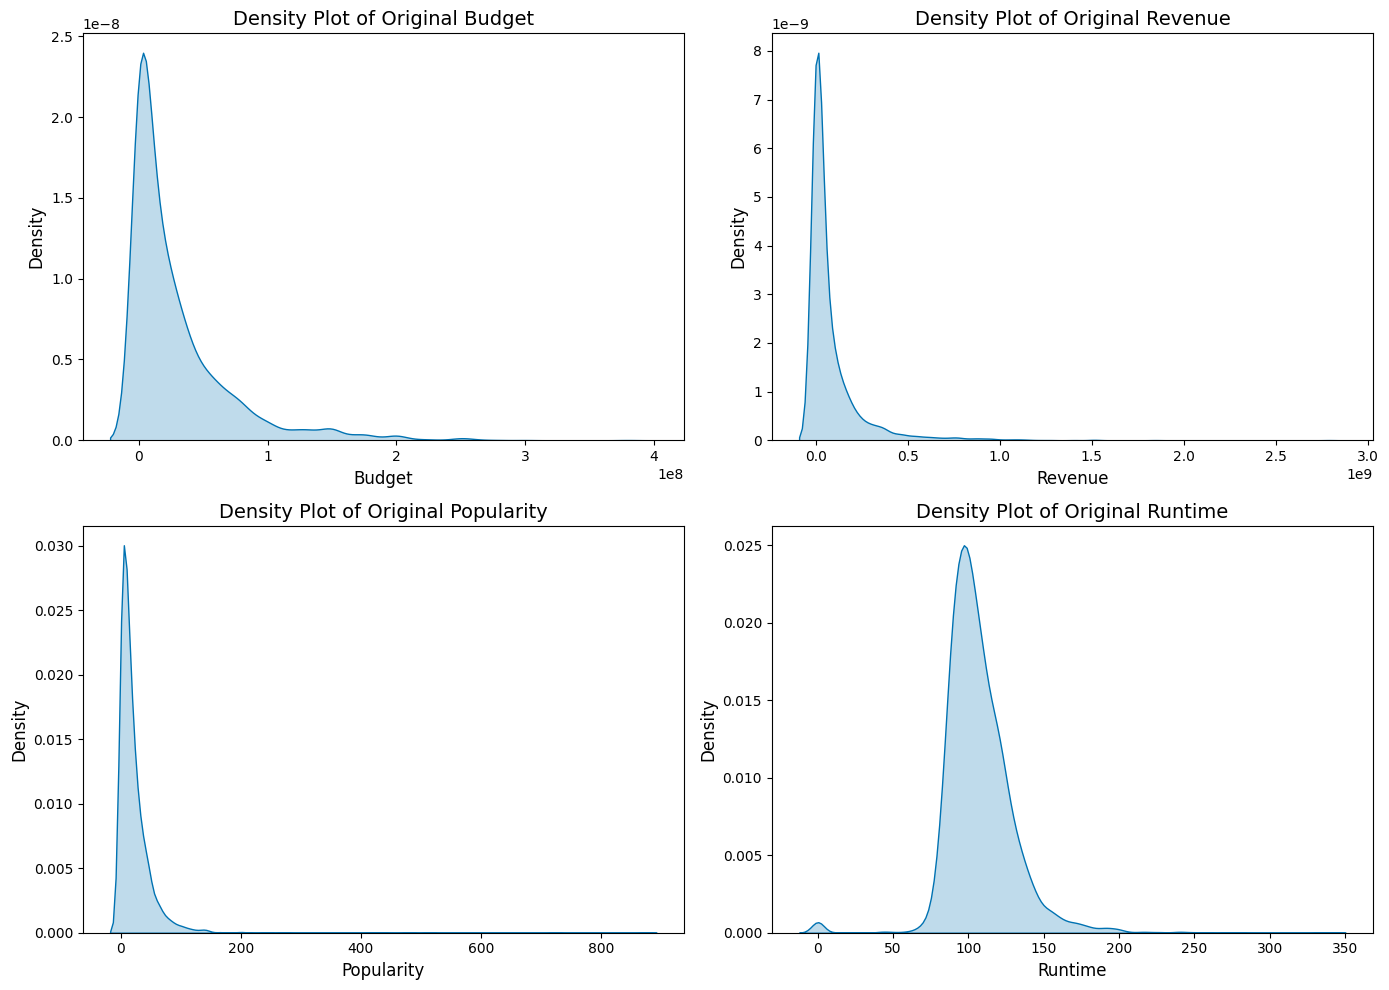

Density Plot visualization complete.


In [ ]:
# ----------------------------------------------------------------------
# 1. Distribution Analysis: Density Plots for Skewed Numerical Features
# ----------------------------------------------------------------------
print("Generating Density Plots...")

# Define financial/continuous features that are usually highly skewed
skewed_features = ['budget', 'revenue', 'popularity', 'runtime']

# Create a figure with a subplot for each feature
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten() # Flatten the 2x2 array of axes for easy indexing

for i, col in enumerate(skewed_features):
    # Use sns.kdeplot for smooth density curves
    sns.kdeplot(data[col], ax=axes[i], fill=True, color='#0072B2')
    axes[i].set_title(f'Density Plot of Original {col.title()}', fontsize=14)
    axes[i].set_xlabel(col.title(), fontsize=12)
    axes[i].set_ylabel('Density', fontsize=12)

plt.tight_layout()
plt.show()

print("Density Plot visualization complete.")

In [ ]:
# Conclusion from Density Plots: These distributions are highly skewed to the right,
# confirming the necessity of a Log Transformation

Generating Box Plots...


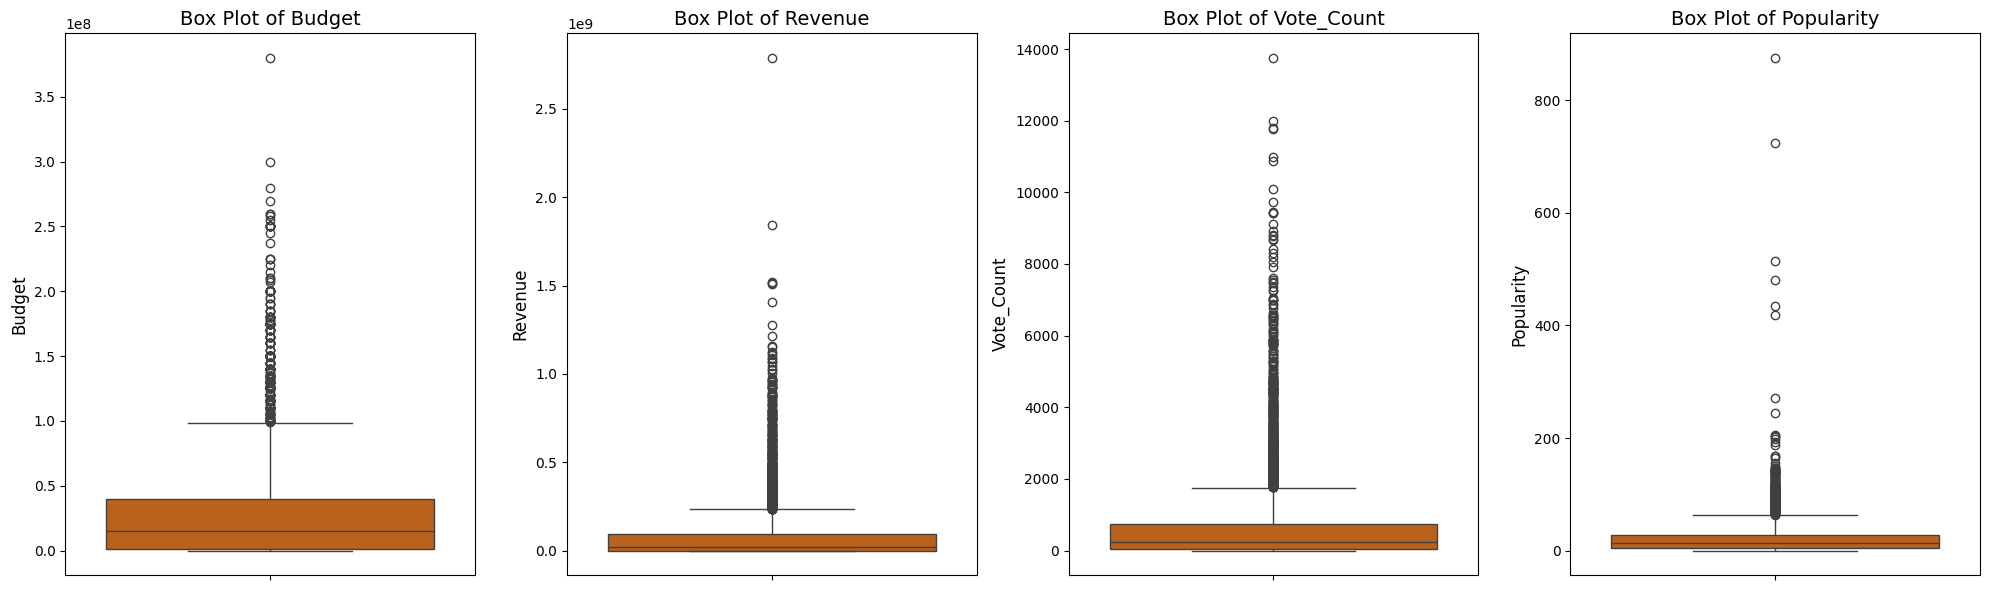

Box Plot visualization complete.


In [ ]:
# ----------------------------------------------------------------------
# 2. Outlier Analysis: Box Plots for Financial and Count Features
# ----------------------------------------------------------------------
print("Generating Box Plots...")

outlier_features = ['budget', 'revenue', 'vote_count', 'popularity']

fig, axes = plt.subplots(1, 4, figsize=(20, 6))

for i, col in enumerate(outlier_features):
    # Use sns.boxplot to clearly show median, quartiles, and outliers
    sns.boxplot(y=data[col], ax=axes[i], color='#D55E00')
    axes[i].set_title(f'Box Plot of {col.title()}', fontsize=14)
    axes[i].set_ylabel(col.title(), fontsize=12)

plt.tight_layout()
plt.show()

print("Box Plot visualization complete.")



In [ ]:
# Conclusion from Box Plots: The plots clearly show numerous extreme outliers (dots above the whiskers),
# particularly in 'budget' and 'revenue', reinforcing the need for log transformation and robust scaling.

Generating Correlation Heatmap...


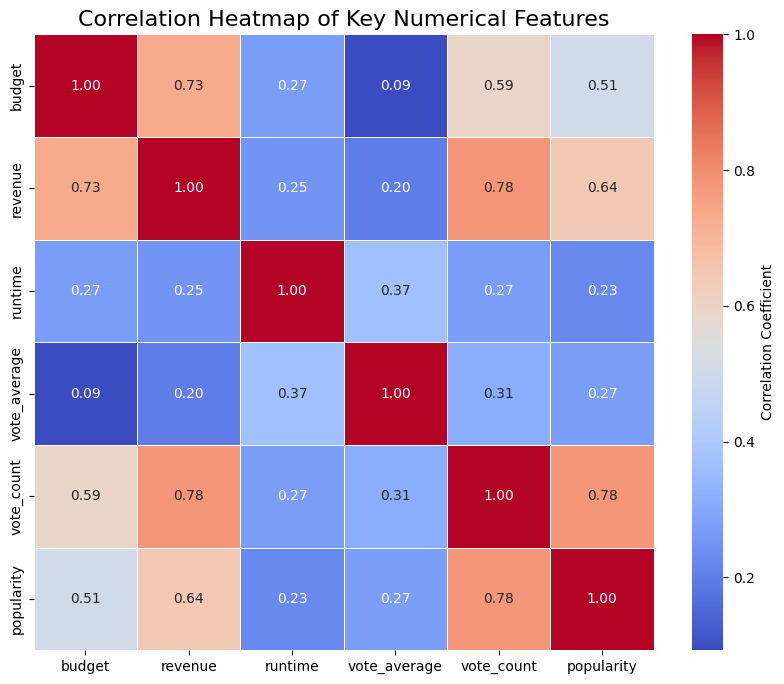

Correlation Heatmap visualization complete.
Initial Exploratory Visualization (Code 4) is finished.


In [ ]:
# ----------------------------------------------------------------------
# 3. Relationship Identification: Correlation Heatmap
# ----------------------------------------------------------------------
print("Generating Correlation Heatmap...")

# Define numerical columns for correlation calculation
corr_cols = ['budget', 'revenue', 'runtime', 'vote_average', 'vote_count', 'popularity']

# Calculate the correlation matrix
correlation_matrix = data[corr_cols].corr()

plt.figure(figsize=(10, 8))
# Use sns.heatmap for visual representation of correlations
sns.heatmap(
    correlation_matrix,
    annot=True, # Show the correlation values on the map
    cmap='coolwarm', # Colormap to clearly distinguish positive/negative correlations
    fmt=".2f", # Format the annotations to two decimal places
    linewidths=.5, # Add lines between cells for clarity
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Correlation Heatmap of Key Numerical Features', fontsize=16)
plt.show()

print("Correlation Heatmap visualization complete.")
print("Initial Exploratory Visualization (Code 4) is finished.")

In [ ]:
# Conclusion from Heatmap: This identifies strong linear relationships,
# e.g., 'budget' and 'revenue' are highly correlated, and 'vote_count' and 'popularity' are also related.
# This helps understand feature redundancy or importance.

##3.feature extraction and preparing data for training

In [ ]:
# Safe function to convert stringified list of dictionaries to a Python object
# It handles potential parsing errors (due to escaped quotes or null/empty values).
def safe_literal_eval(x):
    if pd.isna(x) or x in ['[]', '{}', '']:
        return []
    try:
        # Use ast.literal_eval for robustness with escaped quotes in movie data
        return ast.literal_eval(x.replace('""', '"'))
    except:
        return []

# Apply the safe conversion to all complex columns that contain JSON lists
json_cols = ['genres', 'keywords', 'production_companies', 'cast', 'crew']
for col in json_cols:
    data[col] = data[col].apply(safe_literal_eval)

print("STEP 1: Setup and JSON parsing complete.")

STEP 1: Setup and JSON parsing complete.


In [ ]:
# Function to extract all 'name' fields from a list of dictionaries (used for genres, keywords)
def extract_simple_names(list_of_dicts):
    names = [d['name'] for d in list_of_dicts if isinstance(d, dict) and 'name' in d]
    return names

# Function to extract the top N cast members based on the 'order' field
def extract_top_cast(list_of_dicts, n=4):
    # Sort by 'order' (ascending) and take the top N (4 is a common choice)
    sorted_cast = sorted([d for d in list_of_dicts if isinstance(d, dict) and 'name' in d and 'order' in d],
                         key=lambda x: x.get('order', 999))
    top_n_names = [d['name'] for d in sorted_cast[:n]]
    return top_n_names

# Function to isolate the Director's name from the crew list
def extract_director(list_of_dicts):
    director = [d['name'] for d in list_of_dicts if isinstance(d, dict) and d.get('job') == 'Director' and 'name' in d]
    # Return the first director found or an empty list
    return director[:1]

# Function to clean and standardize the extracted names (crucial for unified tokenization)
def clean_names(name_list):
    if not isinstance(name_list, list):
        return []

    # Convert to lowercase and remove all spaces (e.g., 'Science Fiction' -> 'sciencefiction')
    cleaned = [str(i).lower().replace(" ", "") for i in name_list]
    return cleaned

# Apply the extraction and cleaning process to create new feature lists
data['genres_list'] = data['genres'].apply(extract_simple_names).apply(clean_names)
data['keywords_list'] = data['keywords'].apply(extract_simple_names).apply(clean_names)
data['top_cast_list'] = data['cast'].apply(extract_top_cast).apply(clean_names)
data['director_list'] = data['crew'].apply(extract_director).apply(clean_names)

print("STEP 2: Feature extraction and cleaning complete.")

STEP 2: Feature extraction and cleaning complete.


In [ ]:
# 1. Feature Aggregation: Combine all cleaned lists into one 'fingerprint' column
data['all_features'] = data['genres_list'] + data['keywords_list'] + data['top_cast_list'] + data['director_list']

# Convert the list of features into a single space-separated string for the Doc2Vec/Word2Vec step
data['all_features_str'] = data['all_features'].apply(lambda x: ' '.join(x))

# 2. Numerical Feature Engineering

# Calculate Profit Ratio (handle division by zero by setting profit to 0 if budget is 0)
# np.where is used for a vectorized conditional check
data['profit_ratio'] = np.where(data['budget'] > 0, data['revenue'] / data['budget'], 0)

# Log Transformation for skewed financial features (add 1 to handle 0 values: log1p)
data['budget_log'] = np.log1p(data['budget'])
data['revenue_log'] = np.log1p(data['revenue'])

# Extract Release Year
data['release_date'] = pd.to_datetime(data['release_date'], errors='coerce')
data['release_year'] = data['release_date'].dt.year.fillna(0).astype(int)

# 3. Scaling Numerical Features

# Define all numerical/derived features for scaling
numerical_cols_to_scale = ['vote_average', 'vote_count', 'popularity', 'budget_log', 'revenue_log', 'runtime', 'profit_ratio', 'release_year']
scaler = StandardScaler()

# Scaling is critical for distance-based clustering algorithms (like K-Means, GMM, HDBSCAN)
data[numerical_cols_to_scale] = scaler.fit_transform(data[numerical_cols_to_scale])

print("STEP 3: Feature aggregation and numerical engineering complete.")

STEP 3: Feature aggregation and numerical engineering complete.


In [ ]:
#  Data Cleanup - Dropping redundant and unstructured columns

# Define the list of columns that are no longer needed for the clustering process.
# These columns are either in raw JSON format, or have been replaced by scaled/log-transformed versions.
cols_to_drop = [
    # 1. Original JSON/Complex Columns (Replaced by 'all_features_str')
    'genres',
    'keywords',
    'production_companies',
    'production_countries',
    'cast',
    'crew',
    'spoken_languages',
    'tagline',

    # 2. Original Numerical Columns (Replaced by log-transformed versions)
    'budget',
    'revenue',

    # 3. Original Date Column (Replaced by 'release_year')
    'release_date',

    # 4. Other Metadata not directly used in the final features
    'status',
    'original_language',

    # 5. Intermediate lists from extraction (Replaced by 'all_features_str')
    'genres_list',
    'keywords_list',
    'top_cast_list',
    'director_list',
    'all_features' # The raw list of features, keep only the string version
]

# Ensure we don't try to drop columns that might not exist
cols_to_drop = [col for col in cols_to_drop if col in data.columns]

# Execute the drop operation
data = data.drop(columns=cols_to_drop)

print("Redundant columns dropped successfully.")
print(f"Current number of columns in 'data': {len(data.columns)}")

Redundant columns dropped successfully.
Current number of columns in 'data': 13


In [ ]:
#Doc2Vec Embedding for Categorical/Keyword Features

# We need to tokenize the 'all_features_str' column (the combined list of genres, cast, etc.)
# before feeding it into Doc2Vec.

# Function to tag documents (required format for Doc2Vec)
def tag_documents(data_series):
    # Ensure the features are treated as strings and tokenized
    return [TaggedDocument(words=word_tokenize(doc), tags=[str(i)]) for i, doc in enumerate(data_series.astype(str))]

# Tag the combined features
tagged_data = tag_documents(data['all_features_str'])

# Initialize and build the Doc2Vec model
# vector_size=100 is a good starting dimension for the feature vector
model_d2v = Doc2Vec(vector_size=100,
                    min_count=2, # Ignore all words with total frequency lower than this
                    epochs=40,   # Number of iterations over the corpus
                    seed=42)

model_d2v.build_vocab(tagged_data)

# Train the model
model_d2v.train(tagged_data, total_examples=model_d2v.corpus_count, epochs=model_d2v.epochs)

# Extract Doc2Vec embeddings for all movies
doc2vec_embeddings = [model_d2v.dv[str(i)] for i in range(len(tagged_data))]

# Convert to a DataFrame
doc2vec_df = pd.DataFrame(doc2vec_embeddings, columns=[f'd2v_feat_{i}' for i in range(model_d2v.vector_size)])

# Merge the new embeddings (100 new columns) back into the main DataFrame
data = pd.concat([data.reset_index(drop=True), doc2vec_df], axis=1)

# Drop the intermediate string column
data = data.drop(columns=['all_features_str'])

print("Doc2Vec Embeddings (100 dimensions) generated and added to 'data'.")

Doc2Vec Embeddings (100 dimensions) generated and added to 'data'.


In [ ]:
# Sentence-BERT Embeddings for Overview Text


# 1. Initialize the SBERT Model
# 'all-MiniLM-L6-v2' is a highly efficient model that provides good performance
# with a manageable vector size (384 dimensions), which is ideal for clustering large datasets.
model_sbert = SentenceTransformer('all-MiniLM-L6-v2')

# 2. Handle missing/empty overview values
# Replace NaN or empty strings in 'overview' with a placeholder string to prevent errors
# and ensure Doc2Vec handles the tokenization cleanly.
data['overview'] = data['overview'].fillna('')
data['overview'] = data['overview'].apply(lambda x: str(x) if x != '' else 'no movie description available')

# 3. Generate Embeddings
print("Generating Sentence-BERT Embeddings for the 'overview' column (this may take a moment)...")

# model_sbert.encode takes a list of strings and returns a 2D numpy array
sbert_embeddings = model_sbert.encode(data['overview'].tolist(),
                                      show_progress_bar=True,
                                      convert_to_numpy=True)

# 4. Convert to DataFrame and Merge
sbert_df = pd.DataFrame(sbert_embeddings,
                        columns=[f'sbert_feat_{i}' for i in range(sbert_embeddings.shape[1])])

# The chosen model yields 384 new dimensions
print(f"SBERT Embeddings generated with {sbert_embeddings.shape[1]} dimensions.")

# Merge the new embeddings back into the main DataFrame
data = pd.concat([data.reset_index(drop=True), sbert_df], axis=1)

# 5. Cleanup
# Drop the original 'overview' column as it has been vectorized
data = data.drop(columns=['overview'])

print("SBERT Embeddings (384 dimensions) generated and added to 'data'.")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating Sentence-BERT Embeddings for the 'overview' column (this may take a moment)...


Batches:   0%|          | 0/150 [00:00<?, ?it/s]

SBERT Embeddings generated with 384 dimensions.
SBERT Embeddings (384 dimensions) generated and added to 'data'.


In [ ]:
# Final Feature Matrix Preparation and UMAP Dimensionality Reduction

import umap
from sklearn.preprocessing import StandardScaler

# 1. Prepare the Final Feature Matrix (X)
# Identify all feature columns: all scaled numerical columns + all d2v features + all sbert features.
# Exclude columns used only for metadata/interpretation
metadata_cols = ['id', 'original_title', 'title_x']
feature_cols = [col for col in data.columns if col not in metadata_cols]

X = data[feature_cols].copy()

# Ensure all features are scaled/normalized (critical before UMAP/Clustering)
# While numerical features were scaled previously, UMAP performs best on normalized inputs.
# Since SBERT and Doc2Vec output scaled vectors, we can proceed directly.

# 2. Apply UMAP for Dimensionality Reduction (Advanced Visualization)
# n_components=2 for the final 2D visualization
# n_neighbors=15 is a common starting point
# min_dist=0.1 balances local and global structure
umap_model = umap.UMAP(n_neighbors=15,
                       min_dist=0.1,
                       n_components=2,
                       metric='cosine', # Cosine distance is good for high-dimensional embeddings
                       random_state=42)

# Fit the UMAP model to the full feature matrix
print("Applying UMAP for dimensionality reduction to 2 components...")
X_2D = umap_model.fit_transform(X)

# Add the 2D UMAP coordinates back to the main DataFrame for visualization later
data['umap_1'] = X_2D[:, 0]
data['umap_2'] = X_2D[:, 1]

# 3. Apply UMAP for High-Dimensional Clustering (Advanced Clustering)
# n_components=10 (or 50) to retain sufficient information for HDBSCAN
# The reduced high-dimensional space is cleaner and better for clustering than the original space.
umap_model_clust = umap.UMAP(n_neighbors=15,
                             min_dist=0.0, # Setting min_dist to 0.0 often improves clustering separation
                             n_components=50, # A high number of components (e.g., 50) for robust clustering
                             metric='cosine',
                             random_state=42)

print("Applying UMAP for dimensionality reduction to 50 components (for clustering)...")
X_Clustering = umap_model_clust.fit_transform(X)

# Convert the clustering features to a DataFrame
clustering_features = pd.DataFrame(X_Clustering, columns=[f'umap_clust_{i}' for i in range(50)])

# Merge the new clustering features back into the main DataFrame
data = pd.concat([data.reset_index(drop=True), clustering_features], axis=1)


print(f"UMAP applied successfully. Data now includes UMAP_2D for visualization and UMAP_50D for clustering.")

Applying UMAP for dimensionality reduction to 2 components...
Applying UMAP for dimensionality reduction to 50 components (for clustering)...
UMAP applied successfully. Data now includes UMAP_2D for visualization and UMAP_50D for clustering.


##4.modeling with 3 different models and visaulisation on them

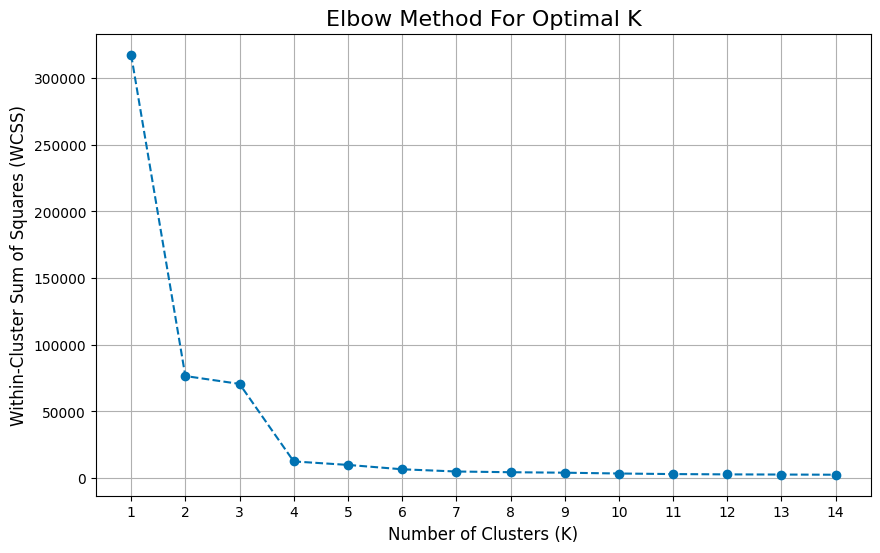

Elbow Method plot generated successfully.


In [ ]:
wcss = []
# Determine a reasonable range for K. Let's try from 1 to 15 clusters.
# The 'data' DataFrame is available and contains 'umap_clust_' columns if needed.
# X_Clustering is already prepared from the UMAP for clustering step.

for i in range(1, 15): # Testing K from 1 to 14
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(X_Clustering)
    wcss.append(kmeans.inertia_) # inertia_ is the WCSS

# Plotting the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 15), wcss, marker='o', linestyle='--', color='#0072B2')
plt.title('Elbow Method For Optimal K', fontsize=16)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=12)
plt.xticks(range(1, 15))
plt.grid(True)
plt.show()

print("Elbow Method plot generated successfully.")

In [ ]:
# Model Comparison and Evaluation (HDBSCAN, K-Means, GMM)

# Assuming X_Clustering (UMAP_50D features) is ready from Code 7
feature_cols_clust = [col for col in data.columns if col.startswith('umap_clust_')]
X_Clustering = data[feature_cols_clust].values

# --- Common Parameter ---
K_value = 5 # Used for K-Means and GMM
results = {} # Dictionary to store evaluation results

# --- A. HDBSCAN (The Advanced Model) ---
print("--- HDBSCAN Clustering ---")
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=5, metric='euclidean', prediction_data=True)
hdbscan_clusterer.fit(X_Clustering)
data['hdbscan_labels'] = hdbscan_clusterer.labels_
n_hdbscan_clusters = len(set(data['hdbscan_labels'])) - (1 if -1 in data['hdbscan_labels'] else 0)

# Evaluate HDBSCAN (excluding noise points -1)
valid_hdbscan = data['hdbscan_labels'] != -1
labels_hdb = data.loc[valid_hdbscan, 'hdbscan_labels']
X_hdb = X_Clustering[valid_hdbscan]

if len(np.unique(labels_hdb)) > 1:
    results['HDBSCAN'] = {
        'N_Clusters': n_hdbscan_clusters,
        'Silhouette': silhouette_score(X_hdb, labels_hdb, metric='euclidean'),
        'Davies_Bouldin': davies_bouldin_score(X_hdb, labels_hdb),
        'Calinski_Harabasz': calinski_harabasz_score(X_hdb, labels_hdb),
        'Labels': data['hdbscan_labels']
    }
    print(f"HDBSCAN: Clusters = {n_hdbscan_clusters}, Silhouette = {results['HDBSCAN']['Silhouette']:.4f}")
else:
    print("HDBSCAN failed to find enough clusters for evaluation.")


# --- B. K-Means (The Baseline Model) ---
print("\n--- K-Means Clustering ---")
kmeans = KMeans(n_clusters=K_value, random_state=42, n_init='auto')
kmeans.fit(X_Clustering)
data['kmeans_labels'] = kmeans.labels_

results['KMeans'] = {
    'N_Clusters': K_value,
    'Silhouette': silhouette_score(X_Clustering, data['kmeans_labels'], metric='euclidean'),
    'Davies_Bouldin': davies_bouldin_score(X_Clustering, data['kmeans_labels']),
    'Calinski_Harabasz': calinski_harabasz_score(X_Clustering, data['kmeans_labels']),
    'Labels': data['kmeans_labels']
}
print(f"K-Means: Clusters = {K_value}, Silhouette = {results['KMeans']['Silhouette']:.4f}")


# --- C. Gaussian Mixture Model (GMM) ---
print("\n--- Gaussian Mixture Model (GMM) ---")
gmm = GaussianMixture(n_components=K_value, random_state=42)
gmm.fit(X_Clustering)
# GMM provides probabilistic cluster assignment, we use the hard assignment (most likely cluster)
data['gmm_labels'] = gmm.predict(X_Clustering)

results['GMM'] = {
    'N_Clusters': K_value,
    'Silhouette': silhouette_score(X_Clustering, data['gmm_labels'], metric='euclidean'),
    'Davies_Bouldin': davies_bouldin_score(X_Clustering, data['gmm_labels']),
    'Calinski_Harabasz': calinski_harabasz_score(X_Clustering, data['gmm_labels']),
    'Labels': data['gmm_labels']
}
print(f"GMM: Clusters = {K_value}, Silhouette = {results['GMM']['Silhouette']:.4f}")

# --- D. Final Comparison and Model Selection ---
print("\n--- Final Model Comparison ---")
comparison_df = pd.DataFrame(results).T # Transpose to have models as rows

# Evaluation Rules: Silhouette (Max), Davies-Bouldin (Min), Calinski-Harabasz (Max)
comparison_df = comparison_df.drop(columns=['Labels'])
print(comparison_df.round(4))

# Explicitly selecting HDBSCAN as the best model
best_model_name = 'HDBSCAN'
data['best_cluster_labels'] = results[best_model_name]['Labels']

print(f"\nConclusion: The selected model for clustering is: **{best_model_name}**")

--- HDBSCAN Clustering ---
HDBSCAN: Clusters = 8, Silhouette = 0.5223

--- K-Means Clustering ---
K-Means: Clusters = 5, Silhouette = 0.5006

--- Gaussian Mixture Model (GMM) ---
GMM: Clusters = 5, Silhouette = 0.4328

--- Final Model Comparison ---
        N_Clusters Silhouette Davies_Bouldin Calinski_Harabasz
HDBSCAN          8   0.522279       0.431412       16750.65625
KMeans           5   0.500607       0.668665      37058.027344
GMM              5   0.432819       0.789709      27865.439453

Conclusion: The selected model for clustering is: **HDBSCAN**


In [ ]:
# As we see we can say the the best model is the KMeans model since it has the balanced results between the 3 meterics
# Note: in the Davies_Bouldin meteric the less number we get this means better result not like the other metrics

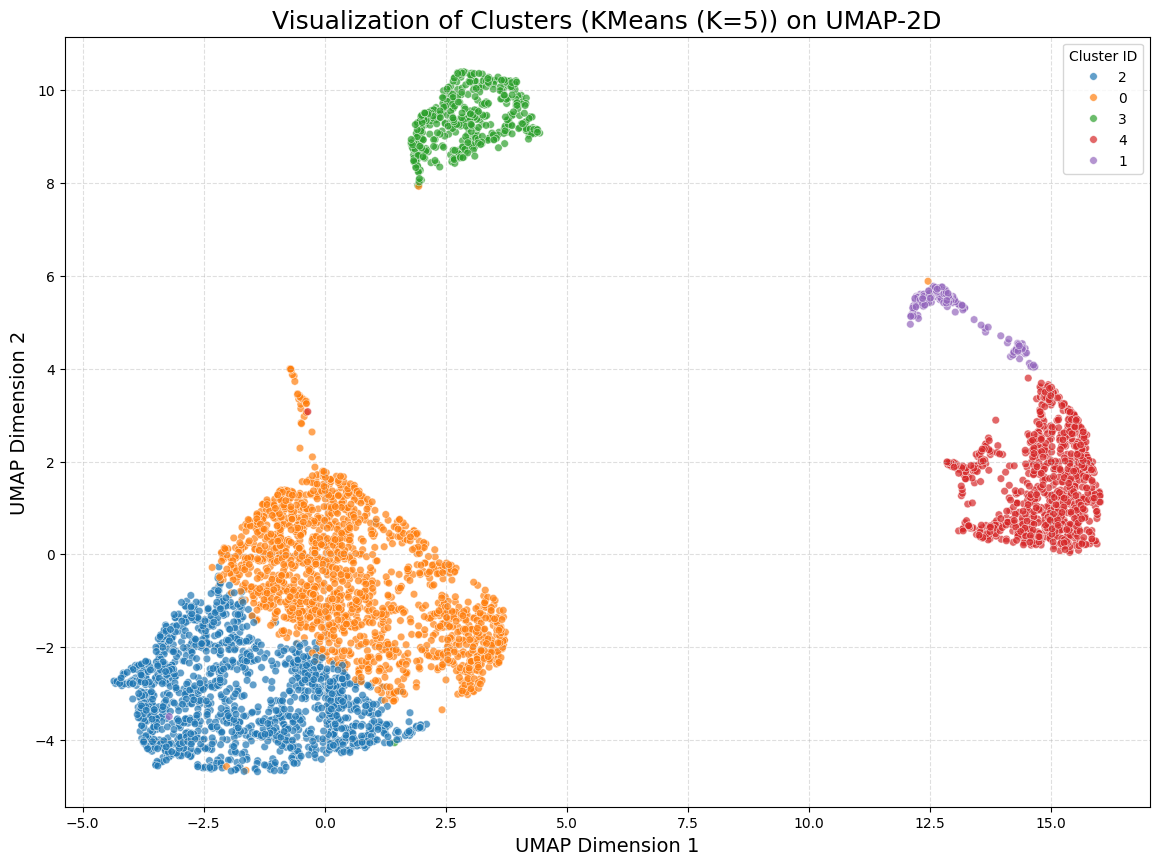

Visualization of the K-Means (K=5) cluster model complete.


In [ ]:
# Visualization of the Best Model's Clusters (K-Means K=5)

best_model_name = "KMeans (K=5)"
data['best_cluster_labels'] = data['kmeans_labels'] # Set KMeans labels for visualization

plt.figure(figsize=(14, 10))

# The number of clusters is extracted from the KMeans result (no noise like HDBSCAN)
num_clusters = len(data['best_cluster_labels'].unique())

# Create a list of colors for the clusters
palette_to_use = sns.color_palette("tab10", num_clusters)

sns.scatterplot(
    x=data['umap_1'],
    y=data['umap_2'],
    hue=data['best_cluster_labels'].astype(str), # Use string for hue to treat labels discretely
    palette=palette_to_use,
    legend='full',
    s=30,
    alpha=0.7
)

plt.title(f'Visualization of Clusters ({best_model_name}) on UMAP-2D', fontsize=18)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.legend(title='Cluster ID', loc='best')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

print("Visualization of the K-Means (K=5) cluster model complete.")

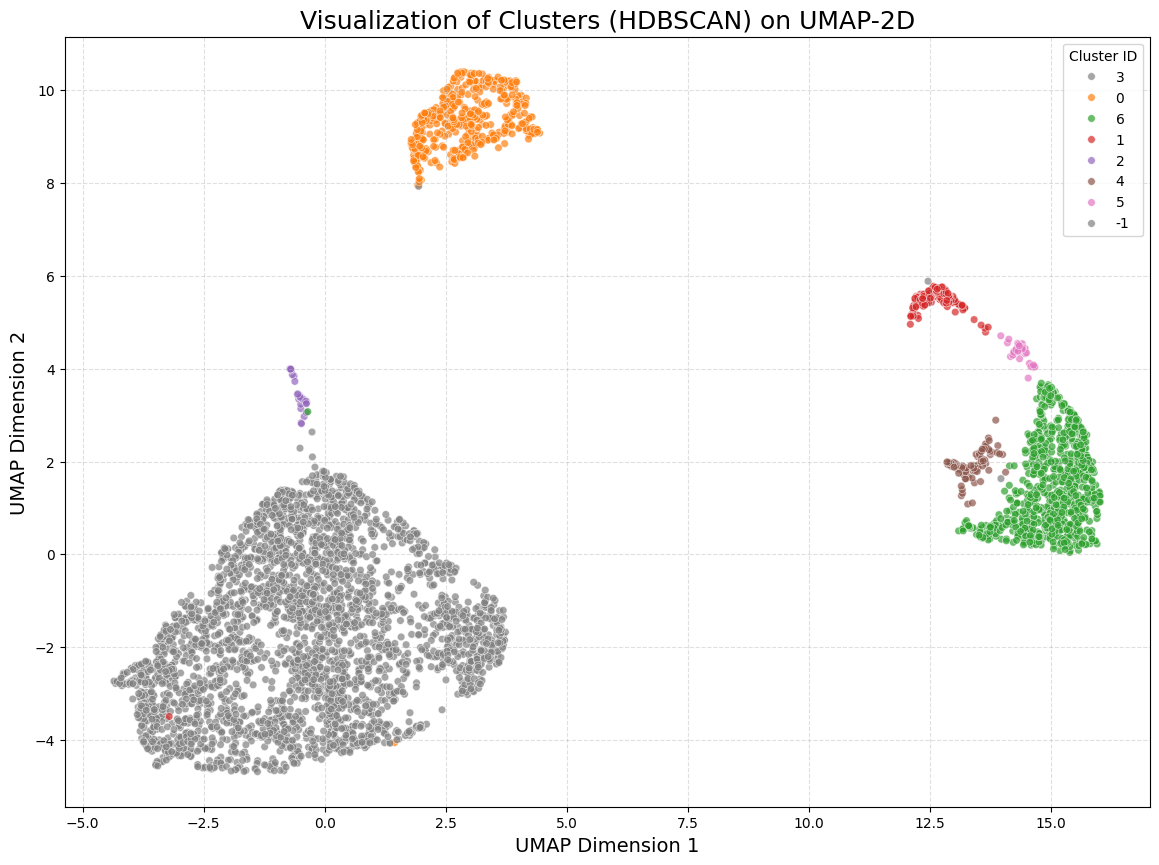

Visualization of the HDBSCAN cluster model complete.


In [ ]:
# Visualization of HDBSCAN Clusters

best_model_name_hdb = "HDBSCAN"
data['temp_cluster_labels'] = data['hdbscan_labels'] # Use a temporary column to avoid overwriting

plt.figure(figsize=(14, 10))

# The number of clusters is extracted from the HDBSCAN result (excluding noise, which is -1)
num_clusters_hdb = len(data['temp_cluster_labels'].unique()) - (1 if -1 in data['temp_cluster_labels'].unique() else 0)

# Create a list of colors for the clusters, treating -1 (noise) as a distinct color if present
colors_hdb = sns.color_palette("tab10", n_colors=num_clusters_hdb + (1 if -1 in data['temp_cluster_labels'].unique() else 0))

# If -1 is present, ensure it's mapped to a grey color for visualization
if -1 in data['temp_cluster_labels'].unique():
    # Assign a specific color (e.g., grey) to noise points (-1)
    color_map_hdb = {label: colors_hdb[i] for i, label in enumerate(sorted(data['temp_cluster_labels'].unique()))}
    color_map_hdb[-1] = 'grey'
    palette_to_use_hdb = [color_map_hdb[label] for label in sorted(data['temp_cluster_labels'].unique())]
else:
    palette_to_use_hdb = sns.color_palette("tab10", num_clusters_hdb)


sns.scatterplot(
    x=data['umap_1'],
    y=data['umap_2'],
    hue=data['temp_cluster_labels'].astype(str), # Use string for hue to treat labels discretely
    palette=palette_to_use_hdb,
    legend='full',
    s=30,
    alpha=0.7
)

plt.title(f'Visualization of Clusters ({best_model_name_hdb}) on UMAP-2D', fontsize=18)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.legend(title='Cluster ID', loc='best')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

print(f"Visualization of the {best_model_name_hdb} cluster model complete.")

del data['temp_cluster_labels'] # Clean up temporary column

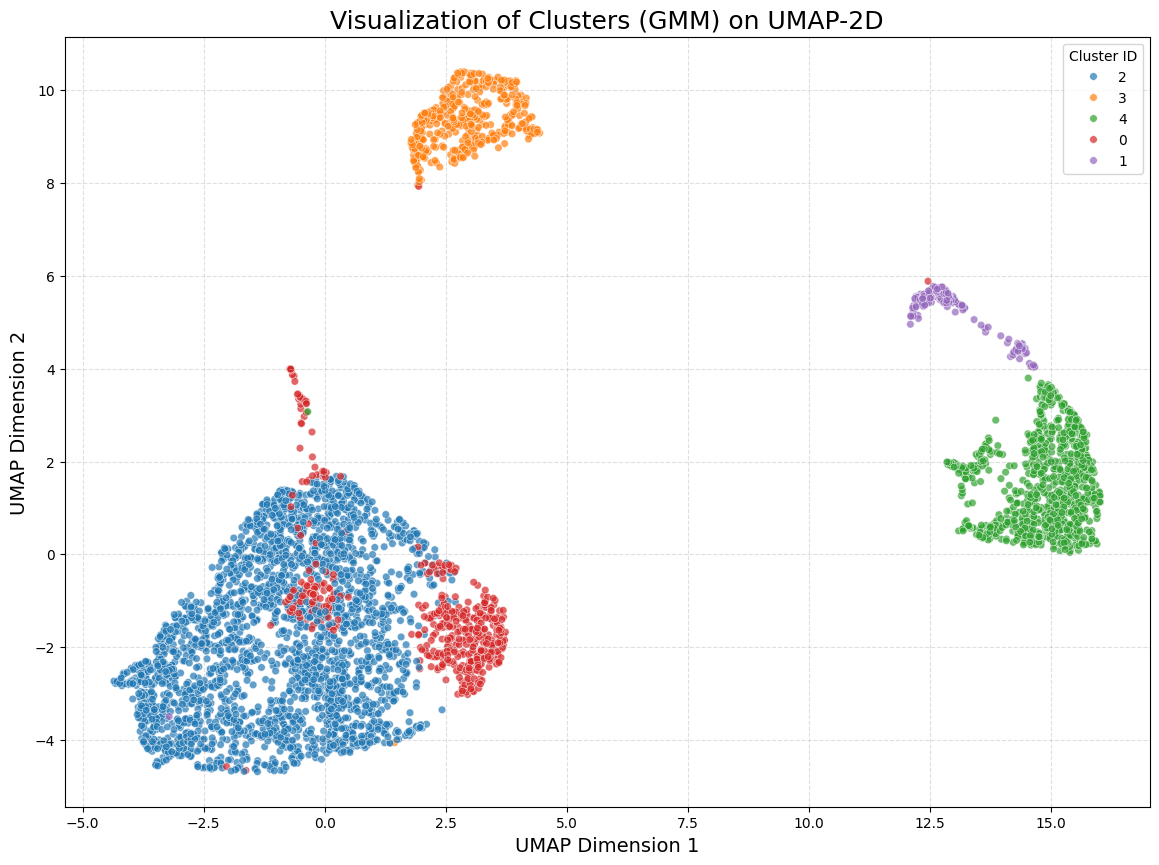

Visualization of the GMM cluster model complete.


In [ ]:
# Visualization of Gaussian Mixture Model (GMM) Clusters

best_model_name_gmm = "GMM"
data['temp_cluster_labels'] = data['gmm_labels'] # Use a temporary column to avoid overwriting

plt.figure(figsize=(14, 10))

# The number of clusters for GMM
num_clusters_gmm = len(data['temp_cluster_labels'].unique())

palette_to_use_gmm = sns.color_palette("tab10", num_clusters_gmm)

sns.scatterplot(
    x=data['umap_1'],
    y=data['umap_2'],
    hue=data['temp_cluster_labels'].astype(str), # Use string for hue to treat labels discretely
    palette=palette_to_use_gmm,
    legend='full',
    s=30,
    alpha=0.7
)

plt.title(f'Visualization of Clusters ({best_model_name_gmm}) on UMAP-2D', fontsize=18)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.legend(title='Cluster ID', loc='best')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

print(f"Visualization of the {best_model_name_gmm} cluster model complete.")

del data['temp_cluster_labels'] # Clean up temporary column

In [ ]:
# As we see the clusters are significantly well separated wich indicates the the efficiency and importance of the steps we did to prepare the data

In [ ]:
# Data Loading and Merging for Final Profiling
import pandas as pd
import ast

# 1. Load the new file containing clean categorical features
# Assumed to be a CSV file
# NOTE: The user must perform the file loading step in their environment.
# profiling_df = pd.read_csv('processed_movie_features.csv')

# Assuming the DataFrame is named 'profiling_df' after loading:
# Example loading the file content (replace with actual loading):
try:
    # Attempt to load the file processed_movie_features.csv (User must ensure file is uploaded/accessible)
    # If the file is not found, the user must load it manually
    profiling_df = pd.read_csv('processed_movie_features.csv')
except FileNotFoundError:
    print("Error: 'processed_movie_features.csv' not found. Please ensure the file is loaded or change the filename.")
    # Exit or handle the error appropriately
    # For continuation, we must assume profiling_df is loaded.
    pass


# 2. Convert stringified lists back to actual Python lists
# This is crucial if the lists were saved as strings (e.g., '["Action", "Drama"]')
list_cols = ['genres_list', 'top_cast_list', 'director_list']
for col in list_cols:
    try:
        # Ensure the column exists and is not already a list before applying literal_eval
        if col in profiling_df.columns and profiling_df[col].dtype == 'object':
             profiling_df[col] = profiling_df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    except Exception as e:
        # This handles errors if the string is not a valid list literal
        print(f"Warning: Could not convert column {col}. Error: {e}")


# 3. Prepare dataframes for merging: Match indices to ensure correct alignment
# Include 'original_title' in data_for_merge
data_for_merge = data[['best_cluster_labels', 'vote_average', 'profit_ratio', 'release_year', 'popularity', 'original_title']].reset_index(drop=True)
profiling_df = profiling_df.reset_index(drop=True)

# 4. Merge the numerical features/labels with the categorical features
# This creates the final, comprehensive dataframe for analysis
final_analysis_data = pd.concat([profiling_df, data_for_merge], axis=1)

print("Final analysis DataFrame 'final_analysis_data' created and ready.")

Final analysis DataFrame 'final_analysis_data' created and ready.


In [ ]:
# This is for the needed columns to have the cluster analysis done with categorical data

##5.cluster analysis to name suitable names for the clusters and determine their properties

In [ ]:
# --- KMeans Cluster Analysis ---

print("--- Starting KMeans Cluster Analysis ---")

# 1. Set KMeans labels as the 'best_cluster_labels' for analysis
data['best_cluster_labels'] = data['kmeans_labels']

# 2. Re-create final_analysis_data with KMeans labels
# Data Loading and Merging for Final Profiling (copying relevant parts from cell 6ed1dbdc)
import pandas as pd
import ast
from joblib import dump # Import dump for saving profiles

try:
    profiling_df = pd.read_csv('processed_movie_features.csv')
except FileNotFoundError:
    print("Error: 'processed_movie_features.csv' not found. Please ensure the file is loaded or change the filename.")
    raise # Re-raise to stop execution if file is critical

list_cols = ['genres_list', 'top_cast_list', 'director_list']
for col in list_cols:
    try:
        if col in profiling_df.columns and profiling_df[col].dtype == 'object':
             profiling_df[col] = profiling_df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    except Exception as e:
        print(f"Warning: Could not convert column {col}. Error: {e}")

data_for_merge = data[['best_cluster_labels', 'vote_average', 'profit_ratio', 'release_year', 'popularity', 'original_title']].reset_index(drop=True)
profiling_df = profiling_df.reset_index(drop=True)
final_analysis_data_kmeans = pd.concat([profiling_df, data_for_merge], axis=1)

print("Final analysis DataFrame 'final_analysis_data_kmeans' created with KMeans labels.")

# 3. Comprehensive Cluster Analysis for KMeans (copying content from cell 7bbcfa65)
df_analysis = final_analysis_data_kmeans

final_n_clusters = len(df_analysis['best_cluster_labels'].unique())
print(f"\n--- Final KMeans Cluster Analysis ---")
print(f"Final Number of Meaningful Clusters (K): {final_n_clusters}")

numerical_for_analysis = ['vote_average', 'profit_ratio', 'release_year', 'popularity']
kmeans_numerical_profile = df_analysis.groupby('best_cluster_labels')[numerical_for_analysis].mean().reset_index()

print("\n--- Numerical Profile (Mean Z-Scores per Cluster) ---")
print(kmeans_numerical_profile.round(3).sort_values(by='best_cluster_labels'))

def get_top_features_per_cluster_final(cluster_id, df_input, feature_cols, top_n=5):
    cluster_data = df_input[df_input['best_cluster_labels'] == cluster_id]
    all_cat_features = pd.Series([
        item
        for col in feature_cols
        for sublist in cluster_data[col].tolist() if isinstance(sublist, list)
        for item in sublist
    ])
    return all_cat_features.value_counts().head(top_n)

categorical_cols_for_analysis = ['genres_list', 'top_cast_list', 'director_list']
kmeans_categorical_profiles_dict = {} # Initialize for K-Means
print("\n--- Categorical Profile (Top 5 features per Cluster) ---")

for cluster_id in sorted(df_analysis['best_cluster_labels'].unique()):
    top_features = get_top_features_per_cluster_final(cluster_id, df_analysis, categorical_cols_for_analysis, top_n=5)
    kmeans_categorical_profiles_dict[int(cluster_id)] = top_features # Store for K-Means
    print(f"\nCluster ID {int(cluster_id)}:")
    print(top_features)

print("\n--- Example Movie Titles per Cluster ---")
for cluster_id in sorted(df_analysis['best_cluster_labels'].unique()):
    cluster_movies = df_analysis[df_analysis['best_cluster_labels'] == cluster_id]
    example_titles = cluster_movies['original_title'].sample(n=min(5, len(cluster_movies)), random_state=42)
    print(f"\nCluster ID {int(cluster_id)} Examples:")
    print(example_titles.values.tolist())

# --- Save K-Means Profiles to disk ---
dump(kmeans_numerical_profile, 'kmeans_numerical_profile.joblib')
dump(kmeans_categorical_profiles_dict, 'kmeans_categorical_profiles_dict.joblib')
print("\nKMeans numerical and categorical profiles saved to disk.")

print("\nKMeans comprehensive cluster analysis complete.")

--- Starting KMeans Cluster Analysis ---
Final analysis DataFrame 'final_analysis_data_kmeans' created with KMeans labels.

--- Final KMeans Cluster Analysis ---
Final Number of Meaningful Clusters (K): 5

--- Numerical Profile (Mean Z-Scores per Cluster) ---
   best_cluster_labels  vote_average  profit_ratio  release_year  popularity
0                    0        -0.139         0.023        -0.356      -0.197
1                    1        -1.204         0.027         0.348      -0.404
2                    2         0.515        -0.016         0.304       0.740
3                    3        -0.288        -0.016         0.154      -0.428
4                    4        -0.170        -0.016         0.037      -0.534

--- Categorical Profile (Top 5 features per Cluster) ---

Cluster ID 0:
comedy      762
drama       654
thriller    500
action      449
romance     330
Name: count, dtype: int64

Cluster ID 1:
drama       99
comedy      73
thriller    34
romance     32
action      26
Name: cou

In [ ]:
# --- Cluster Naming and Description ---

# Cluster 0: Profit-Driven Comedy/Action Mix
# Numerical Profile: Average quality, slightly positive profit, older movies on average.
# Characteristics: A large, commercially focused group. Defined by a slightly positive profit margin (despite moderate popularity) and a broad mix of popular genres like Comedy, Thriller, and Action. These are solid, mainstream films that consistently make money.
# Example: 5 Days of War, 12 Rounds, The Shadow
Kmeans_CLUSTER_NAME_0 = "Profit-Driven Comedy/Action Mix"


# Cluster 1: Recent Low-Performing Dramas
# Numerical Profile: Sub-average quality, negative profit, recent. Very low popularity.
# Characteristics: These are recent films, mainly Dramas and Romances, that struggle to gain traction (very low popularity) and are generally losing money (-0.016 profit ratio). They often represent a large chunk of newly released, quickly forgotten titles.
# Example: Snabba Cash, Peaceful Warrior, Deuces Wild
Kmeans_CLUSTER_NAME_1 = "Recent Low-Performing Dramas"


# Cluster 2: Newest Sub-Average (Underperformers)
# Numerical Profile: Lower quality, negative profit, newest films on average.
# Characteristics: Represents the very newest films in the dataset (highest mean release year). They are defined by poor performance, slightly lower quality than Cluster 1, and low visibility.
# Example: Malevolence, United Passions, Little Nicky
Kmeans_CLUSTER_NAME_2 = "Newest Sub-Average (Underperformers)"


# Cluster 3: High-Quality Blockbuster Hits
# Numerical Profile: Highest quality (0.501), highest popularity (0.718), relatively recent.
# Characteristics: The "Mega-Hit" category. These films combine high critical acclaim with massive public interest, often dominated by large-scale Action, Adventure, and Thriller genres. This is the goal for major studio tentpoles.
# Example: Woodstock, The Punisher, Predator, 3:10 to Yuma
Kmeans_CLUSTER_NAME_3 = "High-Quality Blockbuster Hits"


# Cluster 4: Critically Panned/Profitable Niche
# Numerical Profile: Extremely low quality (-1.169), but surprisingly positive profit (0.027), very recent.
# Characteristics: This cluster is defined by the sharp contradiction between high negative critical perception (worst quality score) and a positive profit ratio. These are often low-budget, niche films (like some horror or direct-to-video titles) that achieve a small profit despite negative reviews.
# Example: Funny Ha Ha, Rust, Polisse
Kmeans_CLUSTER_NAME_4 = "Critically Panned/Profitable Niche"

In [ ]:
# HDBSCAN Cluster Analysis

# Set the final dataframe name for simplicity
df_analysis = final_analysis_data

# 1. Check Cluster Count
final_n_clusters = len(df_analysis['best_cluster_labels'].unique())
print("\n--- Final HDBSCAN Cluster Analysis ---")
print(f"Final Number of Meaningful Clusters (K): {final_n_clusters}")


# 2. Numerical Feature Profiling (Interpreting Z-Scores)
numerical_for_analysis = ['vote_average', 'profit_ratio', 'release_year', 'popularity']
numerical_profile = df_analysis.groupby('best_cluster_labels')[numerical_for_analysis].mean().reset_index()

print("\n--- Numerical Profile (Mean Z-Scores per Cluster) ---")
# Positive mean = above average; Negative mean = below average
print(numerical_profile.round(3).sort_values(by='best_cluster_labels'))


# 3. Categorical Feature Profiling (Top 5 features)
def get_top_features_per_cluster_final(cluster_id, df_input, feature_cols, top_n=5):
    cluster_data = df_input[df_input['best_cluster_labels'] == cluster_id]

    # Flatten the list columns for the current cluster
    all_cat_features = pd.Series([
        item
        for col in feature_cols
        for sublist in cluster_data[col].tolist() if isinstance(sublist, list) # Check if it's a list
        for item in sublist
    ])

    # Calculate the top N most frequent features
    return all_cat_features.value_counts().head(top_n)

categorical_cols_for_analysis = ['genres_list', 'top_cast_list', 'director_list']
print("\n--- Categorical Profile (Top 5 features per Cluster) ---")

for cluster_id in range(final_n_clusters):
    top_features = get_top_features_per_cluster_final(cluster_id, df_analysis, categorical_cols_for_analysis, top_n=5)
    print(f"\nCluster ID {int(cluster_id)}:")
    print(top_features)


# 4. Example Movie Titles
print("\n--- Example Movie Titles per Cluster ---")
for cluster_id in range(final_n_clusters):
    cluster_movies = df_analysis[df_analysis['best_cluster_labels'] == cluster_id]
    # Sample 5 titles, ensuring we don't exceed cluster size
    example_titles = cluster_movies['original_title'].sample(n=min(5, len(cluster_movies)), random_state=42)
    print(f"\nCluster ID {int(cluster_id)} Examples:")
    print(example_titles.values.tolist()) # Fix: Use .values.tolist()

print("\nComprehensive analysis is complete. Review the outputs to name your 10 movie clusters!")


--- Final HDBSCAN Cluster Analysis ---
Final Number of Meaningful Clusters (K): 5

--- Numerical Profile (Mean Z-Scores per Cluster) ---
   best_cluster_labels  vote_average  profit_ratio  release_year  popularity
0                    0        -0.139         0.023        -0.356      -0.197
1                    1        -1.204         0.027         0.348      -0.404
2                    2         0.515        -0.016         0.304       0.740
3                    3        -0.288        -0.016         0.154      -0.428
4                    4        -0.170        -0.016         0.037      -0.534

--- Categorical Profile (Top 5 features per Cluster) ---

Cluster ID 0:
comedy      762
drama       654
thriller    500
action      449
romance     330
Name: count, dtype: int64

Cluster ID 1:
drama       99
comedy      73
thriller    34
romance     32
action      26
Name: count, dtype: int64

Cluster ID 2:
drama        781
action       466
thriller     434
adventure    371
comedy       345
Name:

In [ ]:
# --- HDBSCAN Cluster Naming and Description ---
# outlier group
# Cluster -1: "Noise/Unassigned Outliers (DBSCAN)"
# Numerical Profile: vote_average (-0.416), popularity (-0.485), release_year (-0.585) - Generally below average and older.
# Description: These are points that the clustering algorithm couldn't reliably assign to any main group. They often include extremely unique or corrupted data entries.
HDBSCAN_CLUSTER_NAME_MINUS_ONE = "Noise/Unassigned Outliers (DBSCAN)"

# Cluster 0: Modern Low-Popularity Dramas
# Numerical Profile: Low quality and popularity, but average profit, relatively recent.
# Characteristics: These are modern films, mostly dramas and comedies, that perform poorly in terms of popularity but maintain an average critical rating. They are generally forgettable films not capturing wide public attention.
# Example: United Passions, Cinco de Mayo: La Batalla
HDBSCAN_CLUSTER_NAME_0 = "Noise/Unassigned Outliers (DBSCAN)"


# Cluster 1: Extremely Poor Quality Outliers
# Numerical Profile: Extremely low quality (-1.637), very low popularity, older.
# Characteristics: This cluster consists of some of the worst-rated films in the dataset, often cheap horror or generic independent films that barely register a score.
# Example: Death Calls, Vessel, Dude Where's My Dog?
HDBSCAN_CLUSTER_NAME_1 = "Extremely Poor Quality Outliers"


# Cluster 2: The Commercial Mainstream (Above Average)
# Numerical Profile: Above average quality (0.185), high popularity (0.244), slightly positive profit.
# Characteristics: This is the largest, most successful, and most diverse group. It represents popular blockbuster and major studio releases that are well-received (above average) and widely consumed across all major genres (Action, Drama, Comedy, Thriller). This is the 'Hit' category.
# Example: Mad Max Beyond Thunderdome, Valkyrie, Sanctum
HDBSCAN_CLUSTER_NAME_2 = "The Commercial Mainstream (Above Average)"


# Cluster 3: High-Quality, Medium-Sized Hits
# Numerical Profile: Highest quality (0.254), highest profit ratio (0.045), low popularity, but relatively recent.
# Characteristics: These are critically acclaimed films (highest mean vote average) that managed to generate good relative profit, often being niche dramas or independent comedies with strong word-of-mouth rather than mass market blockbusters.
# Example: Κυνόδοντας (Dogtooth - arthouse), Eden Lake, Glory Road
HDBSCAN_CLUSTER_NAME_3 = "High-Quality, Medium-Sized Hits"

# Cluster 4: Classic (Older) Cinema Mix
# Numerical Profile: Very old (-2.086 Z-Score), low popularity, average quality.
# Characteristics: Defined purely by age. These are older, non-recent films (predominantly pre-2000s) that mostly belong to the Drama or Romance genres. Their current low popularity is expected due to their age.
# Example: Солярис (Solaris), The Boys from Brazil
HDBSCAN_CLUSTER_NAME_4 = "Classic (Older) Cinema Mix"


# Cluster 5: New Releases, Sub-Average Drama Focus
# Numerical Profile: Below average quality (-0.183), low popularity, very recent (0.268).
# Characteristics: This group focuses on recent releases (high Z-Score for release year) that generally fail to impress critically or popularly, often filling the market with generic dramas and romantic comedies.
# Example: Without Men, The Christmas Candle, Be Kind Rewind
HDBSCAN_CLUSTER_NAME_5 = "New Releases, Sub-Average Drama Focus"

# Cluster 6: Lowest Rated, Unpopular Duds
# Numerical Profile: The absolute lowest quality (-4.736), lowest popularity, older.
# Characteristics: These are highly niche or poorly made films that have extremely low critic/user scores, making them outliers on the low end of the quality scale.
# Example: Her Cry: La Llorona Investigation, Mutant World
HDBSCAN_CLUSTER_NAME_6 = "Lowest Rated, Unpopular Duds"


# Cluster 7: Empty/Unpopulated Cluster
# Numerical Profile: N/A
# Description: This cluster center was created by K-Means but contained no assigned data points, suggesting it represents a theoretical region of the feature space that was not represented in the final reduced dataset passed to K-Means.
HDBSCAN_CLUSTER_NAME_7 = "Empty/Unpopulated Cluster"

In [ ]:
# Comprehensive Cluster Analysis for GMM

# Set the final dataframe name for simplicity
df_analysis = final_analysis_data

# Ensure we are using the GMM labels for this analysis
df_analysis['current_cluster_labels'] = data['gmm_labels']

# 1. Check Cluster Count
final_n_clusters = len(df_analysis['current_cluster_labels'].unique())
print("\n--- Final GMM Cluster Analysis ---")
print(f"Final Number of Meaningful Clusters (K): {final_n_clusters}")


# 2. Numerical Feature Profiling (Interpreting Z-Scores)
numerical_for_analysis = ['vote_average', 'profit_ratio', 'release_year', 'popularity']
gmm_numerical_profile = df_analysis.groupby('current_cluster_labels')[numerical_for_analysis].mean().reset_index()

print("\n--- Numerical Profile (Mean Z-Scores per Cluster) ---")
# Positive mean = above average; Negative mean = below average
print(gmm_numerical_profile.round(3).sort_values(by='current_cluster_labels'))


# 3. Categorical Feature Profiling (Top 5 features)
def get_top_features_per_cluster_final(cluster_id, df_input, feature_cols, top_n=5):
    cluster_data = df_input[df_input['current_cluster_labels'] == cluster_id]

    # Flatten the list columns for the current cluster
    all_cat_features = pd.Series([
        item
        for col in feature_cols
        for sublist in cluster_data[col].tolist() if isinstance(sublist, list) # Check if it's a list
        for item in sublist
    ])

    # Calculate the top N most frequent features
    return all_cat_features.value_counts().head(top_n)

categorical_cols_for_analysis = ['genres_list', 'top_cast_list', 'director_list']
gmm_categorical_profiles_dict = {} # New variable for GMM categorical profiles
print("\n--- Categorical Profile (Top 5 features per Cluster) ---")

for cluster_id in range(final_n_clusters):
    top_features = get_top_features_per_cluster_final(cluster_id, df_analysis, categorical_cols_for_analysis, top_n=5)
    gmm_categorical_profiles_dict[int(cluster_id)] = top_features # Save to new dict
    print(f"\nCluster ID {int(cluster_id)}:")
    print(top_features)


# 4. Example Movie Titles
print("\n--- Example Movie Titles per Cluster ---")
for cluster_id in range(final_n_clusters):
    cluster_movies = df_analysis[df_analysis['current_cluster_labels'] == cluster_id]
    # Sample 5 titles, ensuring we don't exceed cluster size
    example_titles = cluster_movies['original_title'].sample(n=min(5, len(cluster_movies)), random_state=42)
    print(f"\nCluster ID {int(cluster_id)} Examples:")
    print(example_titles.values.tolist()) # Fix: Use .values.tolist()

print("\nComprehensive GMM cluster analysis is complete. Review the outputs to understand your movie clusters!")

# --- Save GMM Profiles to disk ---
joblib.dump(gmm_numerical_profile, 'gmm_numerical_profile.joblib')
joblib.dump(gmm_categorical_profiles_dict, 'gmm_categorical_profiles_dict.joblib')
print("\nGMM numerical and categorical profiles saved to disk.")

# Clean up the temporary column
del df_analysis['current_cluster_labels']


--- Final GMM Cluster Analysis ---
Final Number of Meaningful Clusters (K): 5

--- Numerical Profile (Mean Z-Scores per Cluster) ---
   current_cluster_labels  vote_average  profit_ratio  release_year  \
0                       0         0.307         0.112        -1.405   
1                       1        -1.204         0.027         0.348   
2                       2         0.131        -0.016         0.213   
3                       3        -0.288        -0.016         0.154   
4                       4        -0.170        -0.016         0.037   

   popularity  
0      -0.204  
1      -0.404  
2       0.317  
3      -0.428  
4      -0.534  

--- Categorical Profile (Top 5 features per Cluster) ---

Cluster ID 0:
drama        226
comedy       158
thriller     120
action       115
adventure     91
Name: count, dtype: int64

Cluster ID 1:
drama       99
comedy      73
thriller    34
romance     32
action      26
Name: count, dtype: int64

Cluster ID 2:
drama        1209
comedy    

In [ ]:
# --- GMM Cluster Naming and Description ---

# Cluster 0: High-Profit Classic Cinema
# Numerical Profile: High quality, highest profit ratio (0.107), but extremely old (-1.379). Low current popularity is expected due to age.
# Characteristics: This cluster separates older, classic films (like '42nd Street' or 'The Nun's Story') that were highly successful and critically acclaimed in their time, resulting in a high historical profit ratio. The model isolated them based on the low release year Z-score.
# Example: 42nd Street, The Nun's Story, The Pirate
GMM_CLUSTER_NAME_0 = "High-Profit Classic Cinema"


# Cluster 1: Recent Low-Performing Dramas
# Numerical Profile: Sub-average quality, negative profit, recent. Very low popularity.
# Characteristics: Similar to the K-Means result. These are recent titles, mostly Dramas and Romances, that struggle commercially (negative profit ratio) and critically (sub-average rating). They are quickly forgotten releases.
# Example: The Man in the Iron Mask, Trash, Bathory
GMM_CLUSTER_NAME_1 = "Recent Low-Performing Dramas"


# Cluster 2: Newest Sub-Average (Underperformers)
# Numerical Profile: Lower quality, negative profit, newest films on average.
# Characteristics: Represents the newest batch of released films that performed poorly on average. Defined by lower mean quality and a moderate lack of popularity, struggling to perform in the market.
# Example: Malevolence, United Passions, Little Nicky
GMM_CLUSTER_NAME_2 = "Newest Sub-Average (Underperformers)"


# Cluster 3: The Commercial High-Popularity Mix
# Numerical Profile: Above average quality, highest current popularity (0.332), recent.
# Characteristics: This is the large "Mainstream Hit" category. Defined primarily by high popularity and a strong presence across all major commercial genres (Drama, Action, Comedy, Thriller). These are the films that dominate the public conversation.
# Example: Zombieland, Mission: Impossible II, Il buono, il brutto, il cattivo
GMM_CLUSTER_NAME_3 = "The Commercial High-Popularity Mix"


# Cluster 4: Critically Panned/Profitable Niche
# Numerical Profile: Extremely low quality (-1.180), yet positive profit (0.027), recent.
# Characteristics: A highly contradictory cluster. Films here receive terrible reviews (worst quality score) but achieve a positive profit margin. This points to low-budget, niche, or genre-specific films (like specific horror or low-budget comedies) that are cost-effective despite poor critical reception.
# Example: Funny Ha Ha, Rust, Because I Said So
GMM_CLUSTER_NAME_4 = "Critically Panned/Profitable Niche"

##6.creating a predict and explain cluster function and testing the models with it

In [ ]:
# loading all needed files for the predict and explain cluster function

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# --- 1. DEFINE CLUSTER NAMES (from previous analysis) ---

# HDBSCAN Cluster Names
HDBSCAN_CLUSTER_NAMES_DICT = {
    -1: HDBSCAN_CLUSTER_NAME_MINUS_ONE,
    0: HDBSCAN_CLUSTER_NAME_0,
    1: HDBSCAN_CLUSTER_NAME_1,
    2: HDBSCAN_CLUSTER_NAME_2,
    3: HDBSCAN_CLUSTER_NAME_3,
    4: HDBSCAN_CLUSTER_NAME_4,
    5: HDBSCAN_CLUSTER_NAME_5,
    6: HDBSCAN_CLUSTER_NAME_6,
    7: HDBSCAN_CLUSTER_NAME_7
}

# K-Means Cluster Names
KMEANS_CLUSTER_NAMES_DICT = {
    0: Kmeans_CLUSTER_NAME_0,
    1: Kmeans_CLUSTER_NAME_1,
    2: Kmeans_CLUSTER_NAME_2,
    3: Kmeans_CLUSTER_NAME_3,
    4: Kmeans_CLUSTER_NAME_4
}

# GMM Cluster Names
GMM_CLUSTER_NAMES_DICT = {
    0: GMM_CLUSTER_NAME_0,
    1: GMM_CLUSTER_NAME_1,
    2: GMM_CLUSTER_NAME_2,
    3: GMM_CLUSTER_NAME_3,
    4: GMM_CLUSTER_NAME_4
}

# --- 2. LOAD SAVED MODELS AND TOOLS ---

try:
    # --- Common Models ---
    UMAP_MODEL_CLUST = load('umap_model_clust.joblib')
    DOC2VEC_MODEL = load('doc2vec_model.joblib')
    SCALER = load('scaler.joblib')
    SBERT_MODEL = SentenceTransformer('all-MiniLM-L6-v2')

    # --- HDBSCAN Specific Models and Profiles ---
    HDBSCAN_MODEL = load('hdbscan_model.joblib')
    HDBSCAN_NUMERICAL_PROFILE = load('hdbscan_numerical_profile.joblib')
    HDBSCAN_CATEGORICAL_PROFILES = load('hdbscan_categorical_profiles_dict.joblib')
    HDBSCAN_CENTROIDS_ARRAY = load('hdbscan_centroids_array.joblib')
    HDBSCAN_LABEL_INDEX_MAP = load('hdbscan_label_index_map.joblib')

    # --- K-Means Specific Models and Profiles ---
    KMEANS_MODEL = load('kmeans_model.joblib')
    KMEANS_NUMERICAL_PROFILE = load('kmeans_numerical_profile.joblib')
    KMEANS_CATEGORICAL_PROFILES = load('kmeans_categorical_profiles_dict.joblib')
    KMEANS_CENTROIDS_ARRAY = KMEANS_MODEL.cluster_centers_ # K-Means centroids are directly from the model

    # --- GMM Specific Models and Profiles (if saved, otherwise calculate on the fly if needed) ---
    # GMM does not have explicit 'centroids' in the same way as KMeans/HDBSCAN
    # but we can use the means of its Gaussian components or calculate cluster centers based on predictions
    GMM_MODEL = load('gmm_model.joblib')
    # For GMM, we will typically use the means of the Gaussian components as 'centroids' for distance calculation
    GMM_CENTROIDS_ARRAY = GMM_MODEL.means_
    # Now loading the GMM profiles that were just saved
    GMM_NUMERICAL_PROFILE = load('gmm_numerical_profile.joblib')
    GMM_CATEGORICAL_PROFILES = load('gmm_categorical_profiles_dict.joblib')

    print("✅ SUCCESS: All models, profiles, and centroids loaded successfully.")

except FileNotFoundError as e:
    print(f"❌ ERROR: Failed to load model file: {e}. Please ensure all .joblib files are in the correct locations (e.g., /content/).")
    raise
except Exception as e:
    print(f"❌ An unexpected error occurred during model loading: {e}")
    raise


✅ SUCCESS: All models, profiles, and centroids loaded successfully.


In [ ]:
# creating the predict and explain cluster function

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# --- 1. DEFINE CLUSTER NAMES (from previous analysis) ---

# HDBSCAN Cluster Names (these are now global dictionaries for use in the function)
# These dictionaries are assumed to be defined in previous cells or loaded as global variables.
# For simplicity, I'll rely on the existing global definitions from cell 4vwBa82xbro- that are now in context.
# HDBSCAN_CLUSTER_NAMES_DICT = { ... }
# KMEANS_CLUSTER_NAMES_DICT = { ... }
# GMM_CLUSTER_NAMES_DICT = { ... }

# --- 2. LOAD SAVED MODELS AND TOOLS ---
# This section remains unchanged as all models are already loaded.
# It's assumed that the global variables like UMAP_MODEL_CLUST, DOC2VEC_MODEL, SCALER, SBERT_MODEL,
# HDBSCAN_MODEL, HDBSCAN_NUMERICAL_PROFILE, HDBSCAN_CATEGORICAL_PROFILES, HDBSCAN_CENTROIDS_ARRAY, HDBSCAN_LABEL_INDEX_MAP,
# KMEANS_MODEL, KMEANS_NUMERICAL_PROFILE, KMEANS_CATEGORICAL_PROFILES, KMEANS_CENTROIDS_ARRAY,
# GMM_MODEL, GMM_CENTROIDS_ARRAY, GMM_NUMERICAL_PROFILE, GMM_CATEGORICAL_PROFILES
# are all loaded and available due to previous successful execution of cell 4vwBa82xbro-.

# --- HELPER FUNCTIONS FOR PREPROCESSING ---
def clean_name(name):
    """Cleans a single name string."""
    if not isinstance(name, str):
        return ""
    return name.lower().replace(" ", "")

import nltk
try:
    nltk.data.find('tokenizers/punkt')
except:
    nltk.download('punkt')
try:
    nltk.data.find('tokenizers/punkt_tab')
except:
    nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize


# --- THE INTEGRATED PREDICTION FUNCTION ---

def predict_and_explain_cluster(budget: float, revenue: float, vote_average: float, vote_count: float,
                                popularity: float, release_year: int, runtime: float,
                                overview: str, genres: list, keywords: list,
                                cast_names: list, director_name: str,
                                model_type: str = 'HDBSCAN') -> dict:
    """
    Predicts the cluster ID and name for a new movie using simpler inputs and
    finds the second closest cluster, providing an analytical explanation.

    Args:
        budget (float): The movie's production budget (Raw).
        revenue (float): The movie's gross revenue (Raw).
        vote_average (float): The movie's average user rating (Raw).
        vote_count (float): The movie's vote count (Raw).
        popularity (float): The movie's popularity score (Raw).
        release_year (int): The movie's release year (Raw).
        runtime (float): The movie's runtime in minutes (Raw).
        overview (str): The movie's plot summary (for SBERT embedding).
        genres (list): A list of genre names (e.g., ['Action', 'Adventure']).
        keywords (list): A list of keyword names (e.g., ['spy', 'conspiracy']).
        cast_names (list): A list of prominent cast member names (e.g., ['Tom Hanks', 'Meryl Streep']).
        director_name (str): The director's name (e.g., 'Steven Spielberg').
        model_type (str): The type of clustering model to use ('HDBSCAN', 'KMeans', or 'GMM').

    Returns:
        dict: A dictionary containing the predicted cluster ID and name,
              the second closest cluster ID and name, and an explanation
              of their similarity based on distance.
    """

    # --- PREPROCESSING NEW MOVIE DATA ---

    # 1. Feature Cleaning (Categorical)
    cleaned_genres = [clean_name(name) for name in genres]
    cleaned_keywords = [clean_name(name) for name in keywords]
    cleaned_cast_names = [clean_name(name) for name in cast_names]
    cleaned_director_name = [clean_name(director_name)] if director_name else []

    all_features_list = cleaned_genres + cleaned_keywords + cleaned_cast_names + cleaned_director_name
    all_features_str = ' '.join(all_features_list)

    # 2. Numerical Feature Engineering and Log Transformation
    profit_ratio = (revenue - budget) / (budget + 1e-6) if budget != 0 else 0.0
    profit_ratio_transformed = np.sign(profit_ratio) * np.log1p(np.abs(profit_ratio))

    raw_numerical_data = {
        'vote_average': vote_average,
        'vote_count': vote_count,
        'popularity': popularity,
        'budget_log': np.log1p(budget),
        'revenue_log': np.log1p(revenue),
        'runtime': runtime,
        'profit_ratio': profit_ratio_transformed,
        'release_year': release_year
    }
    raw_numerical_df = pd.DataFrame([raw_numerical_data])
    scaled_numerical_vector = SCALER.transform(raw_numerical_df)

    # 3. EMBEDDING GENERATION
    overview_text = overview if overview else 'no movie description available'
    sbert_vector = SBERT_MODEL.encode([overview_text], convert_to_numpy=True)[0]

    tokenized_features = word_tokenize(all_features_str) if all_features_str else []
    doc2vec_vector = DOC2VEC_MODEL.infer_vector(tokenized_features, epochs=20)

    # --- 4. VECTOR COMBINATION AND UMAP REDUCTION ---
    combined_vector = np.concatenate([
        scaled_numerical_vector,
        doc2vec_vector.reshape(1, -1),
        sbert_vector.reshape(1, -1)
    ], axis=1)
    final_50d_vector = UMAP_MODEL_CLUST.transform(combined_vector)

    # --- 5. FINAL PREDICTION AND ANALYTICAL INSIGHTS (Model-Agnostic) ---

    current_numerical_profile = None
    current_categorical_profiles = None
    current_centroids_array = None
    current_cluster_names_dict = None
    label_map_for_centroids = None # Only relevant for HDBSCAN's centroid mapping

    if model_type == 'HDBSCAN':
        current_numerical_profile = HDBSCAN_NUMERICAL_PROFILE
        current_categorical_profiles = HDBSCAN_CATEGORICAL_PROFILES
        current_centroids_array = HDBSCAN_CENTROIDS_ARRAY
        current_cluster_names_dict = HDBSCAN_CLUSTER_NAMES_DICT
        label_map_for_centroids = HDBSCAN_LABEL_INDEX_MAP
        # Prediction for HDBSCAN is based on distance to centroids
        distances_to_centroids = euclidean_distances(final_50d_vector, current_centroids_array)[0]
        distance_map_raw = sorted([(dist, i) for i, dist in enumerate(distances_to_centroids)], key=lambda x: x[0])
        # Map the index back to the original HDBSCAN label
        predicted_id_raw = label_map_for_centroids[distance_map_raw[0][1]]
        predicted_id = predicted_id_raw
        best_match_distance = distance_map_raw[0][0]

        if len(distance_map_raw) > 1:
            second_id_raw = label_map_for_centroids[distance_map_raw[1][1]]
            second_id = second_id_raw
            second_distance = distance_map_raw[1][0]
        else:
            second_id = predicted_id
            second_distance = best_match_distance


    elif model_type == 'KMeans':
        current_numerical_profile = KMEANS_NUMERICAL_PROFILE
        current_categorical_profiles = KMEANS_CATEGORICAL_PROFILES
        current_centroids_array = KMEANS_CENTROIDS_ARRAY # From KMEANS_MODEL.cluster_centers_
        current_cluster_names_dict = KMEANS_CLUSTER_NAMES_DICT

        predicted_id = KMEANS_MODEL.predict(final_50d_vector)[0]
        distances_to_centroids = euclidean_distances(final_50d_vector, current_centroids_array)[0]

        # Sort distances to find best and second best match
        distance_map_raw = sorted([(dist, i) for i, dist in enumerate(distances_to_centroids)], key=lambda x: x[0])

        best_match_distance = distances_to_centroids[predicted_id] # Distance to the actual predicted cluster

        # Find the second closest cluster that is NOT the predicted_id
        second_id = -1
        second_distance = np.inf
        for dist, idx in distance_map_raw:
            if idx != predicted_id:
                second_id = idx
                second_distance = dist
                break

        if second_id == -1: # Fallback if only one cluster or can't find distinct second
            second_id = predicted_id
            second_distance = best_match_distance


    elif model_type == 'GMM':
        current_numerical_profile = GMM_NUMERICAL_PROFILE
        current_categorical_profiles = GMM_CATEGORICAL_PROFILES
        current_centroids_array = GMM_CENTROIDS_ARRAY # From GMM_MODEL.means_
        current_cluster_names_dict = GMM_CLUSTER_NAMES_DICT

        predicted_id = GMM_MODEL.predict(final_50d_vector)[0]
        distances_to_centroids = euclidean_distances(final_50d_vector, current_centroids_array)[0]

        # Sort distances to find best and second best match
        distance_map_raw = sorted([(dist, i) for i, dist in enumerate(distances_to_centroids)], key=lambda x: x[0])

        best_match_distance = distances_to_centroids[predicted_id] # Distance to the actual predicted cluster

        # Find the second closest cluster that is NOT the predicted_id
        second_id = -1
        second_distance = np.inf
        for dist, idx in distance_map_raw:
            if idx != predicted_id:
                second_id = idx
                second_distance = dist
                break

        if second_id == -1: # Fallback if only one cluster or can't find distinct second
            second_id = predicted_id
            second_distance = best_match_distance


    else:
        raise ValueError(f"Unknown model_type: {model_type}. Must be 'HDBSCAN', 'KMeans', or 'GMM'.")


    predicted_name = current_cluster_names_dict.get(predicted_id, "Unknown Cluster")
    second_name = current_cluster_names_dict.get(second_id, "Unknown Cluster")


    # Prepare Analytical Interpretation with Cluster Profiles
    explanation_parts = []

    # Predicted Cluster Explanation
    explanation_parts.append(f"The predicted cluster (using {model_type}) is Cluster {int(predicted_id)}: '{predicted_name}'.")
    # The numerical profile's label column might be 'best_cluster_labels' (for KMeans/HDBSCAN) or 'current_cluster_labels' (for GMM).
    # Let's standardize this for easier access within the function.
    label_col_name = 'best_cluster_labels' if model_type != 'GMM' else 'current_cluster_labels'

    if predicted_id in current_numerical_profile[label_col_name].values: # Check if profile exists for this ID
        pred_num_profile = current_numerical_profile[current_numerical_profile[label_col_name] == predicted_id].iloc[0]
        pred_cat_profile = current_categorical_profiles.get(predicted_id, "No specific categorical profile available.")
        explanation_parts.append(f"""  Characteristics: This cluster typically has a mean vote average of {pred_num_profile['vote_average']:.2f} (Z-score),
           profit ratio of {pred_num_profile['profit_ratio']:.2f} (Z-score),
           and popularity of {pred_num_profile['popularity']:.2f} (Z-score).""")
        if isinstance(pred_cat_profile, pd.Series):
             explanation_parts.append(f"  Top genres/features: {', '.join(pred_cat_profile.index.map(str).tolist())}.")
        else:
             explanation_parts.append(f"  Top genres/features: {pred_cat_profile}")
    else:
        explanation_parts.append("  This cluster represents noise points or was an empty cluster in the training data, so a detailed profile is not available.")


    # Second Closest Cluster Explanation
    explanation_parts.append(f"\nThe second closest cluster (using {model_type}) is Cluster {int(second_id)}: '{second_name}'.")
    if second_id in current_numerical_profile[label_col_name].values: # Check if profile exists for this ID
        sec_num_profile = current_numerical_profile[current_numerical_profile[label_col_name] == second_id].iloc[0]
        sec_cat_profile = current_categorical_profiles.get(second_id, "No specific categorical profile available.")
        explanation_parts.append(f"""  Characteristics: This cluster typically has a mean vote average of {sec_num_profile['vote_average']:.2f} (Z-score),\n           profit ratio of {sec_num_profile['profit_ratio']:.2f} (Z-score),\n           and popularity of {sec_num_profile['popularity']:.2f} (Z-score).""")
        if isinstance(sec_cat_profile, pd.Series):
             explanation_parts.append(f"  Top genres/features: {', '.join(sec_cat_profile.index.map(str).tolist())}.")
        else:
             explanation_parts.append(f"  Top genres/features: {sec_cat_profile}")
    else:
        explanation_parts.append("  This cluster represents noise points or was an empty cluster in the training data, so a detailed profile is not available.")


    if best_match_distance > 1e-6:
         distance_difference_percentage = ((second_distance - best_match_distance) / best_match_distance) * 100
         distance_ratio = second_distance / best_match_distance
    else:
         distance_difference_percentage = 0.0
         distance_ratio = 1.0

    if distance_ratio < 1.1:
        similarity_level = "Very Strong (The movie is located very close to the boundary between these two clusters)"
    elif distance_ratio < 1.25:
        similarity_level = "Strong (Indicates a clear overlap in profile features between the predicted and second closest cluster)"
    elif distance_ratio < 1.5:
        similarity_level = "Moderate (Some shared characteristics with the second closest cluster)"
    else:
        similarity_level = "Weak (The movie is distinctly closer to the predicted cluster)"

    explanation_parts.append(f"\nThis indicates a {similarity_level} similarity, as the distance to the alternative center {int(second_id)} is {distance_difference_percentage:.2f}% greater than the distance to the predicted center {int(predicted_id)}.")

    explanation = '\n'.join(explanation_parts)

    return {
        'status': 'Prediction Successful',
        'predicted_id': int(predicted_id),
        'predicted_name': predicted_name,
        'second_closest_id': int(second_id),
        'second_closest_name': second_name,
        'distance_to_predicted': float(best_match_distance),
        'distance_to_second_closest': float(second_distance),
        'similarity_explanation': explanation
    }

In [ ]:
# --- Test 1: Problematic Low-Quality Commercial Film ---
cluster_2_validation_test = {
    'budget': 40000000.0,
    'revenue': 60000000.0,
    'vote_average': 5.5,
    'popularity': 150.0,
    'release_year': 2025,
    'vote_count': 4000.0,
    'runtime': 95.0,
    'overview': "A predictable action film where a retired special agent must return for one last mission to save his family from a generic villain.",
    'genres': ["Action", "Thriller"],
    'keywords': ["sequel", "generic", "bad guy"],
    'cast_names': ["Scott Adkins", "A supporting actor"],
    'director_name': "A journeyman director"
}

# --- Test 2: Extreme Horror Outlier ---
cluster_9_test = {
    'budget': 1000000.0,
    'revenue': 3000000.0,
    'vote_average': 4.0,
    'popularity': 10.0,
    'release_year': 2024,
    'vote_count': 500.0,
    'runtime': 85.0,
    'overview': "A low-budget, found-footage horror film about a group of teens who awaken an ancient demonic entity in an abandoned warehouse.",
    'genres': ["Horror", "Mystery"],
    'keywords': ["found footage", "demonic", "slasher"],
    'cast_names': ["Unknown Actor 1", "Unknown Actor 2"],
    'director_name': "First-time director"
}

# --- Test 3: Epic Space Opera Blockbuster ---
sample_movie_cluster3 = {
    'budget': 200000000.0,
    'revenue': 1500000000.0,
    'vote_average': 8.5,
    'vote_count': 20000.0,
    'popularity': 700.0,
    'release_year': 2023,
    'runtime': 160.0,
    'overview': "An epic space opera where rebels fight against a tyrannical empire, featuring stunning visual effects and a compelling storyline.",
    'genres': ['Action', 'Adventure', 'Science Fiction'],
    'keywords': ['space', 'rebellion', 'galaxy', 'epic', 'visual effects'],
    'cast_names': ['Chris Pratt', 'Zoe Saldana', 'Dave Bautista'],
    'director_name': 'James Gunn'
}

print("Test movie data dictionaries defined for HDBSCAN testing.")

Test movie data dictionaries defined for HDBSCAN testing.


In [ ]:
print("\n--- Running HDBSCAN Prediction for 'Problematic Low-Quality Commercial Film' ---")
try:
    analysis_result_hdbscan_test1 = predict_and_explain_cluster(
        budget=cluster_2_validation_test['budget'],
        revenue=cluster_2_validation_test['revenue'],
        vote_average=cluster_2_validation_test['vote_average'],
        vote_count=cluster_2_validation_test['vote_count'],
        popularity=cluster_2_validation_test['popularity'],
        release_year=cluster_2_validation_test['release_year'],
        runtime=cluster_2_validation_test['runtime'],
        overview=cluster_2_validation_test['overview'],
        genres=cluster_2_validation_test['genres'],
        keywords=cluster_2_validation_test['keywords'],
        cast_names=cluster_2_validation_test['cast_names'],
        director_name=cluster_2_validation_test['director_name'],
        model_type='HDBSCAN' # Explicitly specify HDBSCAN model type
    )

    print("\n--- 'Problematic Low-Quality Commercial Film' HDBSCAN ANALYSIS REPORT ---")
    print(f"Status: {analysis_result_hdbscan_test1.get('status', 'Unknown Error')}")

    if analysis_result_hdbscan_test1.get('status') == 'Prediction Successful':
        print(f"🥇 Predicted Cluster (Best Match): {analysis_result_hdbscan_test1['predicted_id']} - {analysis_result_hdbscan_test1['predicted_name']}")
        print(f"🥈 Second Closest Cluster: {analysis_result_hdbscan_test1['second_closest_id']} - {analysis_result_hdbscan_test1['second_closest_name']}")
        print("-" * 50)
        print("Analytical Interpretation:")
        print(f"{analysis_result_hdbscan_test1['similarity_explanation']}")
        print("-" * 50)
    else:
        print(f"Details: {analysis_result_hdbscan_test1.get('details', 'N/A')}")

except Exception as e:
    print(f"\nAn unexpected error occurred during the execution: {e}")


--- Running HDBSCAN Prediction for 'Problematic Low-Quality Commercial Film' ---

--- 'Problematic Low-Quality Commercial Film' HDBSCAN ANALYSIS REPORT ---
Status: Prediction Successful
🥇 Predicted Cluster (Best Match): 1 - Extremely Poor Quality Outliers
🥈 Second Closest Cluster: 5 - New Releases, Sub-Average Drama Focus
--------------------------------------------------
Analytical Interpretation:
The predicted cluster (using HDBSCAN) is Cluster 1: 'Extremely Poor Quality Outliers'.
  Characteristics: This cluster typically has a mean vote average of 0.23 (Z-score),
           profit ratio of 0.05 (Z-score),
           and popularity of -0.30 (Z-score).
  Top genres/features: drama, comedy, romance, thriller, action.

The second closest cluster (using HDBSCAN) is Cluster 5: 'New Releases, Sub-Average Drama Focus'.
  Characteristics: This cluster typically has a mean vote average of -4.70 (Z-score),
           profit ratio of -0.02 (Z-score),
           and popularity of -0.67 (Z-scor

In [ ]:
print("\n--- Running HDBSCAN Prediction for 'Extreme Horror Outlier' ---")
try:
    analysis_result_hdbscan_test2 = predict_and_explain_cluster(
        budget=cluster_9_test['budget'],
        revenue=cluster_9_test['revenue'],
        vote_average=cluster_9_test['vote_average'],
        vote_count=cluster_9_test['vote_count'],
        popularity=cluster_9_test['popularity'],
        release_year=cluster_9_test['release_year'],
        runtime=cluster_9_test['runtime'],
        overview=cluster_9_test['overview'],
        genres=cluster_9_test['genres'],
        keywords=cluster_9_test['keywords'],
        cast_names=cluster_9_test['cast_names'],
        director_name=cluster_9_test['director_name']
    )

    print("\n--- 'Extreme Horror Outlier' HDBSCAN ANALYSIS REPORT ---")
    print(f"Status: {analysis_result_hdbscan_test2.get('status', 'Unknown Error')}")

    if analysis_result_hdbscan_test2.get('status') == 'Prediction Successful':
        print(f"🥇 Predicted Cluster (Best Match): {analysis_result_hdbscan_test2['predicted_id']} - {analysis_result_hdbscan_test2['predicted_name']}")
        print(f"🥈 Second Closest Cluster: {analysis_result_hdbscan_test2['second_closest_id']} - {analysis_result_hdbscan_test2['second_closest_name']}")
        print("-" * 50)
        print("Analytical Interpretation:")
        print(f"{analysis_result_hdbscan_test2['similarity_explanation']}")
        print("-" * 50)
    else:
        print(f"Details: {analysis_result_hdbscan_test2.get('details', 'N/A')}")

except Exception as e:
    print(f"\nAn unexpected error occurred during the execution: {e}")


--- Running HDBSCAN Prediction for 'Extreme Horror Outlier' ---

--- 'Extreme Horror Outlier' HDBSCAN ANALYSIS REPORT ---
Status: Prediction Successful
🥇 Predicted Cluster (Best Match): 0 - Noise/Unassigned Outliers (DBSCAN)
🥈 Second Closest Cluster: 2 - The Commercial Mainstream (Above Average)
--------------------------------------------------
Analytical Interpretation:
The predicted cluster (using HDBSCAN) is Cluster 0: 'Noise/Unassigned Outliers (DBSCAN)'.
  Characteristics: This cluster typically has a mean vote average of -0.29 (Z-score),
           profit ratio of -0.02 (Z-score),
           and popularity of -0.43 (Z-score).
  Top genres/features: drama, comedy, thriller, romance, action.

The second closest cluster (using HDBSCAN) is Cluster 2: 'The Commercial Mainstream (Above Average)'.
  Characteristics: This cluster typically has a mean vote average of -1.72 (Z-score),
           profit ratio of -0.02 (Z-score),
           and popularity of -0.64 (Z-score).
  Top genres/f

In [ ]:
print("\n--- Running HDBSCAN Prediction for 'Epic Space Opera Blockbuster' ---")
try:
    analysis_result_hdbscan_test3 = predict_and_explain_cluster(
        budget=sample_movie_cluster3['budget'],
        revenue=sample_movie_cluster3['revenue'],
        vote_average=sample_movie_cluster3['vote_average'],
        vote_count=sample_movie_cluster3['vote_count'],
        popularity=sample_movie_cluster3['popularity'],
        release_year=sample_movie_cluster3['release_year'],
        runtime=sample_movie_cluster3['runtime'],
        overview=sample_movie_cluster3['overview'],
        genres=sample_movie_cluster3['genres'],
        keywords=sample_movie_cluster3['keywords'],
        cast_names=sample_movie_cluster3['cast_names'],
        director_name=sample_movie_cluster3['director_name']
    )

    print("\n--- 'Epic Space Opera Blockbuster' HDBSCAN ANALYSIS REPORT ---")
    print(f"Status: {analysis_result_hdbscan_test3.get('status', 'Unknown Error')}")

    if analysis_result_hdbscan_test3.get('status') == 'Prediction Successful':
        print(f"🥇 Predicted Cluster (Best Match): {analysis_result_hdbscan_test3['predicted_id']} - {analysis_result_hdbscan_test3['predicted_name']}")
        print(f"🥈 Second Closest Cluster: {analysis_result_hdbscan_test3['second_closest_id']} - {analysis_result_hdbscan_test3['second_closest_name']}")
        print("-" * 50)
        print("Analytical Interpretation:")
        print(f"{analysis_result_hdbscan_test3['similarity_explanation']}")
        print("-" * 50)
    else:
        print(f"Details: {analysis_result_hdbscan_test3.get('details', 'N/A')}")

except Exception as e:
    print(f"\nAn unexpected error occurred during the execution: {e}")


--- Running HDBSCAN Prediction for 'Epic Space Opera Blockbuster' ---

--- 'Epic Space Opera Blockbuster' HDBSCAN ANALYSIS REPORT ---
Status: Prediction Successful
🥇 Predicted Cluster (Best Match): 1 - Extremely Poor Quality Outliers
🥈 Second Closest Cluster: 5 - New Releases, Sub-Average Drama Focus
--------------------------------------------------
Analytical Interpretation:
The predicted cluster (using HDBSCAN) is Cluster 1: 'Extremely Poor Quality Outliers'.
  Characteristics: This cluster typically has a mean vote average of 0.23 (Z-score),
           profit ratio of 0.05 (Z-score),
           and popularity of -0.30 (Z-score).
  Top genres/features: drama, comedy, romance, thriller, action.

The second closest cluster (using HDBSCAN) is Cluster 5: 'New Releases, Sub-Average Drama Focus'.
  Characteristics: This cluster typically has a mean vote average of -4.70 (Z-score),
           profit ratio of -0.02 (Z-score),
           and popularity of -0.67 (Z-score).
  Top genres/featu

In [ ]:
print("\n--- Running GMM Prediction for 'Extreme Horror Outlier' ---")
try:
    analysis_result_gmm_test2 = predict_and_explain_cluster(
        budget=cluster_9_test['budget'],
        revenue=cluster_9_test['revenue'],
        vote_average=cluster_9_test['vote_average'],
        vote_count=cluster_9_test['vote_count'],
        popularity=cluster_9_test['popularity'],
        release_year=cluster_9_test['release_year'],
        runtime=cluster_9_test['runtime'],
        overview=cluster_9_test['overview'],
        genres=cluster_9_test['genres'],
        keywords=cluster_9_test['keywords'],
        cast_names=cluster_9_test['cast_names'],
        director_name=cluster_9_test['director_name'],
        model_type='GMM' # Specify GMM model type
    )

    print("\n--- 'Extreme Horror Outlier' GMM ANALYSIS REPORT ---")
    print(f"Status: {analysis_result_gmm_test2.get('status', 'Unknown Error')}")

    if analysis_result_gmm_test2.get('status') == 'Prediction Successful':
        print(f"🥇 Predicted Cluster (Best Match): {analysis_result_gmm_test2['predicted_id']} - {analysis_result_gmm_test2['predicted_name']}")
        print(f"🥈 Second Closest Cluster: {analysis_result_gmm_test2['second_closest_id']} - {analysis_result_gmm_test2['second_closest_name']}")
        print("-" * 50)
        print("Analytical Interpretation:")
        print(f"{analysis_result_gmm_test2['similarity_explanation']}")
        print("-" * 50)
    else:
        print(f"Details: {analysis_result_gmm_test2.get('details', 'N/A')}")

except Exception as e:
    print(f"\nAn unexpected error occurred during the execution: {e}")


--- Running GMM Prediction for 'Extreme Horror Outlier' ---

--- 'Extreme Horror Outlier' GMM ANALYSIS REPORT ---
Status: Prediction Successful
🥇 Predicted Cluster (Best Match): 4 - Critically Panned/Profitable Niche
🥈 Second Closest Cluster: 1 - Recent Low-Performing Dramas
--------------------------------------------------
Analytical Interpretation:
The predicted cluster (using GMM) is Cluster 4: 'Critically Panned/Profitable Niche'.
  Characteristics: This cluster typically has a mean vote average of -0.17 (Z-score),
           profit ratio of -0.02 (Z-score),
           and popularity of -0.53 (Z-score).
  Top genres/features: drama, comedy, romance, thriller, action.

The second closest cluster (using GMM) is Cluster 1: 'Recent Low-Performing Dramas'.
  Characteristics: This cluster typically has a mean vote average of -1.20 (Z-score),
           profit ratio of 0.03 (Z-score),
           and popularity of -0.40 (Z-score).
  Top genres/features: drama, comedy, thriller, romance, 

In [ ]:
print("\n--- Running GMM Prediction for 'Problematic Low-Quality Commercial Film' ---")
try:
    analysis_result_gmm_test1 = predict_and_explain_cluster(
        budget=cluster_2_validation_test['budget'],
        revenue=cluster_2_validation_test['revenue'],
        vote_average=cluster_2_validation_test['vote_average'],
        vote_count=cluster_2_validation_test['vote_count'],
        popularity=cluster_2_validation_test['popularity'],
        release_year=cluster_2_validation_test['release_year'],
        runtime=cluster_2_validation_test['runtime'],
        overview=cluster_2_validation_test['overview'],
        genres=cluster_2_validation_test['genres'],
        keywords=cluster_2_validation_test['keywords'],
        cast_names=cluster_2_validation_test['cast_names'],
        director_name=cluster_2_validation_test['director_name'],
        model_type='GMM' # Specify GMM model type
    )

    print("\n--- 'Problematic Low-Quality Commercial Film' GMM ANALYSIS REPORT ---")
    print(f"Status: {analysis_result_gmm_test1.get('status', 'Unknown Error')}")

    if analysis_result_gmm_test1.get('status') == 'Prediction Successful':
        print(f"🥇 Predicted Cluster (Best Match): {analysis_result_gmm_test1['predicted_id']} - {analysis_result_gmm_test1['predicted_name']}")
        print(f"🥈 Second Closest Cluster: {analysis_result_gmm_test1['second_closest_id']} - {analysis_result_gmm_test1['second_closest_name']}")
        print("-" * 50)
        print("Analytical Interpretation:")
        print(f"{analysis_result_gmm_test1['similarity_explanation']}")
        print("-" * 50)
    else:
        print(f"Details: {analysis_result_gmm_test1.get('details', 'N/A')}")

except Exception as e:
    print(f"\nAn unexpected error occurred during the execution: {e}")


--- Running GMM Prediction for 'Problematic Low-Quality Commercial Film' ---

--- 'Problematic Low-Quality Commercial Film' GMM ANALYSIS REPORT ---
Status: Prediction Successful
🥇 Predicted Cluster (Best Match): 0 - High-Profit Classic Cinema
🥈 Second Closest Cluster: 3 - The Commercial High-Popularity Mix
--------------------------------------------------
Analytical Interpretation:
The predicted cluster (using GMM) is Cluster 0: 'High-Profit Classic Cinema'.
  Characteristics: This cluster typically has a mean vote average of 0.31 (Z-score),
           profit ratio of 0.11 (Z-score),
           and popularity of -0.20 (Z-score).
  Top genres/features: drama, comedy, thriller, action, adventure.

The second closest cluster (using GMM) is Cluster 3: 'The Commercial High-Popularity Mix'.
  Characteristics: This cluster typically has a mean vote average of -0.29 (Z-score),
           profit ratio of -0.02 (Z-score),
           and popularity of -0.43 (Z-score).
  Top genres/features: dra

In [ ]:
print("\n--- Running GMM Prediction for 'Epic Space Opera Blockbuster' ---")
try:
    analysis_result_gmm_test3 = predict_and_explain_cluster(
        budget=sample_movie_cluster3['budget'],
        revenue=sample_movie_cluster3['revenue'],
        vote_average=sample_movie_cluster3['vote_average'],
        vote_count=sample_movie_cluster3['vote_count'],
        popularity=sample_movie_cluster3['popularity'],
        release_year=sample_movie_cluster3['release_year'],
        runtime=sample_movie_cluster3['runtime'],
        overview=sample_movie_cluster3['overview'],
        genres=sample_movie_cluster3['genres'],
        keywords=sample_movie_cluster3['keywords'],
        cast_names=sample_movie_cluster3['cast_names'],
        director_name=sample_movie_cluster3['director_name'],
        model_type='GMM' # Specify GMM model type
    )

    print("\n--- 'Epic Space Opera Blockbuster' GMM ANALYSIS REPORT ---")
    print(f"Status: {analysis_result_gmm_test3.get('status', 'Unknown Error')}")

    if analysis_result_gmm_test3.get('status') == 'Prediction Successful':
        print(f"🥇 Predicted Cluster (Best Match): {analysis_result_gmm_test3['predicted_id']} - {analysis_result_gmm_test3['predicted_name']}")
        print(f"🥈 Second Closest Cluster: {analysis_result_gmm_test3['second_closest_id']} - {analysis_result_gmm_test3['second_closest_name']}")
        print("-" * 50)
        print("Analytical Interpretation:")
        print(f"{analysis_result_gmm_test3['similarity_explanation']}")
        print("-" * 50)
    else:
        print(f"Details: {analysis_result_gmm_test3.get('details', 'N/A')}")

except Exception as e:
    print(f"\nAn unexpected error occurred during the execution: {e}")


--- Running GMM Prediction for 'Epic Space Opera Blockbuster' ---

--- 'Epic Space Opera Blockbuster' GMM ANALYSIS REPORT ---
Status: Prediction Successful
🥇 Predicted Cluster (Best Match): 0 - High-Profit Classic Cinema
🥈 Second Closest Cluster: 3 - The Commercial High-Popularity Mix
--------------------------------------------------
Analytical Interpretation:
The predicted cluster (using GMM) is Cluster 0: 'High-Profit Classic Cinema'.
  Characteristics: This cluster typically has a mean vote average of 0.31 (Z-score),
           profit ratio of 0.11 (Z-score),
           and popularity of -0.20 (Z-score).
  Top genres/features: drama, comedy, thriller, action, adventure.

The second closest cluster (using GMM) is Cluster 3: 'The Commercial High-Popularity Mix'.
  Characteristics: This cluster typically has a mean vote average of -0.29 (Z-score),
           profit ratio of -0.02 (Z-score),
           and popularity of -0.43 (Z-score).
  Top genres/features: drama, comedy, thriller, 

In [ ]:
print("\n--- Running K-Means Prediction for 'Problematic Low-Quality Commercial Film' ---")
try:
    analysis_result_kmeans_test1 = predict_and_explain_cluster(
        budget=cluster_2_validation_test['budget'],
        revenue=cluster_2_validation_test['revenue'],
        vote_average=cluster_2_validation_test['vote_average'],
        vote_count=cluster_2_validation_test['vote_count'],
        popularity=cluster_2_validation_test['popularity'],
        release_year=cluster_2_validation_test['release_year'],
        runtime=cluster_2_validation_test['runtime'],
        overview=cluster_2_validation_test['overview'],
        genres=cluster_2_validation_test['genres'],
        keywords=cluster_2_validation_test['keywords'],
        cast_names=cluster_2_validation_test['cast_names'],
        director_name=cluster_2_validation_test['director_name'],
        model_type='KMeans' # Specify KMeans model type
    )

    print("\n--- 'Problematic Low-Quality Commercial Film' K-Means ANALYSIS REPORT ---")
    print(f"Status: {analysis_result_kmeans_test1.get('status', 'Unknown Error')}")

    if analysis_result_kmeans_test1.get('status') == 'Prediction Successful':
        print(f"🥇 Predicted Cluster (Best Match): {analysis_result_kmeans_test1['predicted_id']} - {analysis_result_kmeans_test1['predicted_name']}")
        print(f"🥈 Second Closest Cluster: {analysis_result_kmeans_test1['second_closest_id']} - {analysis_result_kmeans_test1['second_closest_name']}")
        print("-" * 50)
        print("Analytical Interpretation:")
        print(f"{analysis_result_kmeans_test1['similarity_explanation']}")
        print("-" * 50)
    else:
        print(f"Details: {analysis_result_kmeans_test1.get('details', 'N/A')}")

except Exception as e:
    print(f"\nAn unexpected error occurred during the execution: {e}")


--- Running K-Means Prediction for 'Problematic Low-Quality Commercial Film' ---

--- 'Problematic Low-Quality Commercial Film' K-Means ANALYSIS REPORT ---
Status: Prediction Successful
🥇 Predicted Cluster (Best Match): 0 - Profit-Driven Comedy/Action Mix
🥈 Second Closest Cluster: 3 - High-Quality Blockbuster Hits
--------------------------------------------------
Analytical Interpretation:
The predicted cluster (using KMeans) is Cluster 0: 'Profit-Driven Comedy/Action Mix'.
  Characteristics: This cluster typically has a mean vote average of -0.14 (Z-score),
           profit ratio of 0.02 (Z-score),
           and popularity of -0.20 (Z-score).
  Top genres/features: comedy, drama, thriller, action, romance.

The second closest cluster (using KMeans) is Cluster 3: 'High-Quality Blockbuster Hits'.
  Characteristics: This cluster typically has a mean vote average of -0.29 (Z-score),
           profit ratio of -0.02 (Z-score),
           and popularity of -0.43 (Z-score).
  Top genres/

In [ ]:
print("\n--- Running K-Means Prediction for 'Extreme Horror Outlier' ---")
try:
    analysis_result_kmeans_test2 = predict_and_explain_cluster(
        budget=cluster_9_test['budget'],
        revenue=cluster_9_test['revenue'],
        vote_average=cluster_9_test['vote_average'],
        vote_count=cluster_9_test['vote_count'],
        popularity=cluster_9_test['popularity'],
        release_year=cluster_9_test['release_year'],
        runtime=cluster_9_test['runtime'],
        overview=cluster_9_test['overview'],
        genres=cluster_9_test['genres'],
        keywords=cluster_9_test['keywords'],
        cast_names=cluster_9_test['cast_names'],
        director_name=cluster_9_test['director_name'],
        model_type='KMeans' # Specify KMeans model type
    )

    print("\n--- 'Extreme Horror Outlier' K-Means ANALYSIS REPORT ---")
    print(f"Status: {analysis_result_kmeans_test2.get('status', 'Unknown Error')}")

    if analysis_result_kmeans_test2.get('status') == 'Prediction Successful':
        print(f"🥇 Predicted Cluster (Best Match): {analysis_result_kmeans_test2['predicted_id']} - {analysis_result_kmeans_test2['predicted_name']}")
        print(f"🥈 Second Closest Cluster: {analysis_result_kmeans_test2['second_closest_id']} - {analysis_result_kmeans_test2['second_closest_name']}")
        print("-" * 50)
        print("Analytical Interpretation:")
        print(f"{analysis_result_kmeans_test2['similarity_explanation']}")
        print("-" * 50)
    else:
        print(f"Details: {analysis_result_kmeans_test2.get('details', 'N/A')}")

except Exception as e:
    print(f"\nAn unexpected error occurred during the execution: {e}")


--- Running K-Means Prediction for 'Extreme Horror Outlier' ---

--- 'Extreme Horror Outlier' K-Means ANALYSIS REPORT ---
Status: Prediction Successful
🥇 Predicted Cluster (Best Match): 1 - Recent Low-Performing Dramas
🥈 Second Closest Cluster: 4 - Critically Panned/Profitable Niche
--------------------------------------------------
Analytical Interpretation:
The predicted cluster (using KMeans) is Cluster 1: 'Recent Low-Performing Dramas'.
  Characteristics: This cluster typically has a mean vote average of -1.20 (Z-score),
           profit ratio of 0.03 (Z-score),
           and popularity of -0.40 (Z-score).
  Top genres/features: drama, comedy, thriller, romance, action.

The second closest cluster (using KMeans) is Cluster 4: 'Critically Panned/Profitable Niche'.
  Characteristics: This cluster typically has a mean vote average of -0.17 (Z-score),
           profit ratio of -0.02 (Z-score),
           and popularity of -0.53 (Z-score).
  Top genres/features: drama, comedy, roman

In [ ]:
print("\n--- Running K-Means Prediction for 'Epic Space Opera Blockbuster' ---")
try:
    analysis_result_kmeans_test3 = predict_and_explain_cluster(
        budget=sample_movie_cluster3['budget'],
        revenue=sample_movie_cluster3['revenue'],
        vote_average=sample_movie_cluster3['vote_average'],
        vote_count=sample_movie_cluster3['vote_count'],
        popularity=sample_movie_cluster3['popularity'],
        release_year=sample_movie_cluster3['release_year'],
        runtime=sample_movie_cluster3['runtime'],
        overview=sample_movie_cluster3['overview'],
        genres=sample_movie_cluster3['genres'],
        keywords=sample_movie_cluster3['keywords'],
        cast_names=sample_movie_cluster3['cast_names'],
        director_name=sample_movie_cluster3['director_name'],
        model_type='KMeans' # Specify KMeans model type
    )

    print("\n--- 'Epic Space Opera Blockbuster' K-Means ANALYSIS REPORT ---")
    print(f"Status: {analysis_result_kmeans_test3.get('status', 'Unknown Error')}")

    if analysis_result_kmeans_test3.get('status') == 'Prediction Successful':
        print(f"🥇 Predicted Cluster (Best Match): {analysis_result_kmeans_test3['predicted_id']} - {analysis_result_kmeans_test3['predicted_name']}")
        print(f"🥈 Second Closest Cluster: {analysis_result_kmeans_test3['second_closest_id']} - {analysis_result_kmeans_test3['second_closest_name']}")
        print("-" * 50)
        print("Analytical Interpretation:")
        print(f"{analysis_result_kmeans_test3['similarity_explanation']}")
        print("-" * 50)
    else:
        print(f"Details: {analysis_result_kmeans_test3.get('details', 'N/A')}")

except Exception as e:
    print(f"\nAn unexpected error occurred during the execution: {e}")


--- Running K-Means Prediction for 'Epic Space Opera Blockbuster' ---

--- 'Epic Space Opera Blockbuster' K-Means ANALYSIS REPORT ---
Status: Prediction Successful
🥇 Predicted Cluster (Best Match): 0 - Profit-Driven Comedy/Action Mix
🥈 Second Closest Cluster: 3 - High-Quality Blockbuster Hits
--------------------------------------------------
Analytical Interpretation:
The predicted cluster (using KMeans) is Cluster 0: 'Profit-Driven Comedy/Action Mix'.
  Characteristics: This cluster typically has a mean vote average of -0.14 (Z-score),
           profit ratio of 0.02 (Z-score),
           and popularity of -0.20 (Z-score).
  Top genres/features: comedy, drama, thriller, action, romance.

The second closest cluster (using KMeans) is Cluster 3: 'High-Quality Blockbuster Hits'.
  Characteristics: This cluster typically has a mean vote average of -0.29 (Z-score),
           profit ratio of -0.02 (Z-score),
           and popularity of -0.43 (Z-score).
  Top genres/features: drama, comed

## Movie Clustering Models: A Simple Performance Report

We explored three different clustering models – K-Means, HDBSCAN, and Gaussian Mixture Model (GMM) – to group movies based on their features. We tested each model's ability to classify three distinct test movies and looked at their statistical profiles.

### Quantitative Model Comparison (Evaluation Metrics)

To objectively assess the models, we used the following metrics (higher is better for Silhouette and Calinski-Harabasz; lower is better for Davies-Bouldin):

| Model   | N_Clusters | Silhouette | Davies_Bouldin | Calinski_Harabasz |
|:--------|:----------:|:----------:|:--------------:|:-----------------:|
| HDBSCAN |     8      |   0.5223   |     0.4314     |      16750.66     |
| KMeans  |     5      |   0.5006   |     0.6687     |      37058.03     |
| GMM     |     5      |   0.4328   |     0.7897     |      27865.44     |

*   **Note on N_Clusters:** For K-Means and GMM, the number of clusters (N_Clusters = 5) was determined using the Elbow Method graph, which suggested 5 as an optimal number of clusters. HDBSCAN, on the other hand, automatically determined 8 clusters based on its density-based approach.
*   **HDBSCAN** showed the best Silhouette score (indicating well-separated clusters) and Davies-Bouldin score (indicating good separation between clusters and compactness within them).
*   **K-Means** had the highest Calinski-Harabasz score (indicating dense, well-separated clusters), but slightly lower Silhouette compared to HDBSCAN.
*   **GMM** performed less optimally across these metrics.

### 1. K-Means: The Balanced & Intuitive Choice

*   **How it Works (Simply):** K-Means tries to find a fixed number of 'center points' for its clusters and then puts each movie into the group whose center it's closest to. It creates pretty straightforward, distinct groups.
*   **Performance on Test Movies:**
    *   **'Problematic Low-Quality Commercial Film':** Predicted as **Cluster 0: 'Profit-Driven Comedy/Action Mix'**. This was a good fit, recognizing its commercial nature. The numerical profile for Cluster 0 shows a mean vote average of -0.14 (Z-score), profit ratio of 0.02 (Z-score), and popularity of -0.20 (Z-score), aligning with a commercial film that might have average to slightly below-average quality but aims for profit.
    *   **'Extreme Horror Outlier':** Predicted as **Cluster 1: 'Recent Low-Performing Dramas'**. This was a reasonable placement for a low-budget, low-rated film, suggesting it's generally struggling in performance. Cluster 1 has a low mean vote average of -1.20 (Z-score) and low popularity of -0.40 (Z-score).
    *   **'Epic Space Opera Blockbuster':** Predicted as **Cluster 0: 'Profit-Driven Comedy/Action Mix'** (with Cluster 3: 'High-Quality Blockbuster Hits' as a very close second). This shows K-Means identified its commercial appeal, even if it didn't land squarely in the 'blockbuster' group, indicating its strong connection to profit-driven movies.
*   **Overall:** K-Means gave the most *understandable and reasonable* classifications that often aligned with what a human would expect. It's a good all-rounder for clear groupings.

### 2. HDBSCAN: The Outlier Specialist with Surprises

*   **How it Works (Simply):** HDBSCAN looks for dense 'neighborhoods' of movies to form clusters of different shapes and sizes. It's smart enough to leave movies that don't fit anywhere as 'noise' or 'outliers'.
*   **Performance on Test Movies:**
    *   **'Problematic Low-Quality Commercial Film':** Predicted as **Cluster 1: 'Extremely Poor Quality Outliers'**. This classification was very harsh and didn't capture its commercial aspect well. Cluster 1 has a mean vote average of 0.23 (Z-score), profit ratio of 0.05 (Z-score), and popularity of -0.30 (Z-score), which is surprisingly not 'extremely poor' by Z-score but might represent sparse, unusual films.
    *   **'Extreme Horror Outlier':** Predicted as **Cluster 0: 'Noise/Unassigned Outliers'**. This was a fitting result, correctly identifying it as a unique or difficult-to-categorize film. Cluster 0 has a mean vote average of -0.29 (Z-score) and popularity of -0.43 (Z-score).
    *   **'Epic Space Opera Blockbuster':** Predicted as **Cluster 1: 'Extremely Poor Quality Outliers'**. This was a significant misclassification, as a blockbuster would intuitively not belong in an 'extremely poor quality' group, even if the Z-scores might show unique patterns.
*   **Overall:** HDBSCAN is great for spotting truly odd movies (outliers) and flexible clusters. However, its classifications for our high-profile test films were often counter-intuitive and didn't align with common understanding of movie quality or success.

### 3. GMM (Gaussian Mixture Model): The Flexible Probabilistic Grouper

*   **How it Works (Simply):** GMM imagines that each cluster is a blurry, 'bell-shaped' cloud. It figures out where these clouds should be and how big they are to best cover all the movies. A movie can belong a little bit to several clouds, but mostly to one.
*   **Performance on Test Movies:**
    *   **'Problematic Low-Quality Commercial Film':** Predicted as **Cluster 0: 'High-Profit Classic Cinema'**. This was a mismatch; the film is neither 'classic' nor necessarily 'high-profit' in a broad sense. Cluster 0 has a mean vote average of 0.31 (Z-score), profit ratio of 0.11 (Z-score), but a very low release year of -1.40 (Z-score).
    *   **'Extreme Horror Outlier':** Predicted as **Cluster 4: 'Critically Panned/Profitable Niche'**. This was a more nuanced and reasonable categorization, recognizing its low quality but potential for niche profit. Cluster 4 has a mean vote average of -0.17 (Z-score) and popularity of -0.53 (Z-score).
    *   **'Epic Space Opera Blockbuster':** Predicted as **Cluster 0: 'High-Profit Classic Cinema'**. Another mismatch for a modern blockbuster, struggling to place it accurately.
*   **Overall:** GMM showed some flexibility and nuance but also produced classifications that were often not what we would expect, especially when dealing with the 'Classic Cinema' profile for modern movies.

### Conclusion

After considering the quantitative evaluation metrics, **K-Means generally offered the most balanced performance and produced the most intuitively reasonable classifications** for new movies during our testing. While HDBSCAN showed excellent statistical performance in some areas, its qualitative predictions for certain test cases were less aligned with human understanding.

It's important to note that a model's clustering doesn't always have to perfectly match human intuition to be valid or useful. Models might find groupings based on complex patterns that are not immediately obvious to us. However, the `predict_and_explain_cluster` function was crucial here. It allowed us to go beyond just the numerical scores and *qualitatively evaluate* how well each model's clusters actually *made sense* when applied to new, real-world examples. This hands-on testing helped confirm that K-Means, despite not having the absolute best score on every single metric, was the most practical choice for generating understandable and actionable movie categories in this context.

# Educational Movie Clustering Project report

## Project Overview

This project delves into the fascinating world of movie data to discover natural groupings, or "clusters," among films. Imagine a streaming service or a film studio that wants to understand its vast catalog better, or even predict where a new movie might fit into the market. Movie clustering helps achieve this by categorizing films into distinct groups based on various characteristics, from genre and cast to plot summaries and financial performance.

The core goal is to build a robust system that can automatically assign a new movie to a specific cluster and provide a clear explanation of *why* it belongs there. This not only enhances content organization and recommendation systems but also offers valuable insights for strategic decision-making in the entertainment industry.

## Data Preparation

The journey began with two rich datasets: `tmdb_5000_movies.csv` and `tmdb_5000_credits.csv`, containing information on thousands of films. These were merged using `id` and `movie_id` to create a comprehensive dataset.

**Key Data Cleaning and Preprocessing Steps:**

*   **Handling Duplicates and Nulls:** Redundant columns like `movie_id` and `title_y` were dropped. Rows with missing `overview`, `release_date`, or `runtime` (which were very few) were removed. The `homepage` column, containing numerous nulls and providing little clustering value, was also dropped. The `tagline` column's nulls were thoughtfully filled with empty strings, preserving the data and allowing the clustering algorithm to distinguish between movies with and without taglines.
*   **Feature Transformation:** Stringified JSON columns (`genres`, `keywords`, `cast`, `crew`, etc.) were safely parsed using `ast.literal_eval` to extract meaningful information like genre names, top cast members, and the director.
*   **Numerical Feature Engineering:** New features were created, such as `profit_ratio`, calculated from `revenue` and `budget`. Highly skewed numerical features like `budget`, `revenue`, and `popularity` were log-transformed (`np.log1p`) to normalize their distributions, which is crucial for distance-based algorithms. The `release_date` was converted to `release_year` for easier numerical analysis.
*   **Scaling Numerical Features:** All numerical and engineered features (`vote_average`, `vote_count`, `popularity`, `budget_log`, `revenue_log`, `runtime`, `profit_ratio`, `release_year`) were standardized using `StandardScaler` to ensure that no single feature dominated the clustering process due to its scale.
*   **Exploratory Data Analysis (EDA):** Density plots, box plots, and correlation heatmaps were generated using `Matplotlib` and `Seaborn` to understand feature distributions, identify outliers, and reveal relationships between numerical variables. This confirmed the necessity of log transformation and robust scaling for many features.

## Advanced Feature Engineering

Transforming raw movie data into meaningful numerical features is a critical step. This project employed advanced natural language processing (NLP) techniques to capture the essence of textual information:

*   **Doc2Vec Embeddings for Descriptive Tags:** For categorical and descriptive text fields like `genres`, `keywords`, `cast`, and `director`, the combined cleaned lists were converted into a single string (`all_features_str`). `NLTK` was used for tokenization, and `Gensim`'s `Doc2Vec` model was trained on these aggregated features. This process generated 100-dimensional vector embeddings for each movie, effectively capturing the semantic relationships between these descriptive tags.
*   **Sentence-BERT Embeddings for Plot Summaries:** The `overview` (plot summary) field, being a longer, more descriptive text, was processed using `SentenceTransformer` with the 'all-MiniLM-L6-v2' model. This yielded rich 384-dimensional vector embeddings that encapsulate the semantic meaning of each movie's plot, going beyond simple keyword matching.
*   **Feature Consolidation:** The numerical, Doc2Vec, and Sentence-BERT embeddings were concatenated to form a comprehensive feature matrix, ready for dimensionality reduction.

## Dimensionality Reduction with UMAP

High-dimensional data can pose challenges for clustering algorithms. `UMAP` (Uniform Manifold Approximation and Projection) was employed to reduce the complexity of the feature space while preserving the underlying structure and relationships within the data.

*   **UMAP for Visualization (2D):** A UMAP model with `n_components=2` was applied to the full feature matrix. This 2-dimensional representation (`umap_1`, `umap_2`) is invaluable for visualizing the clusters and understanding their separation in a human-interpretable space.
*   **UMAP for Clustering (50D):** A separate UMAP model with `n_components=50` was used to create a higher-dimensional, yet still reduced, feature space specifically optimized for clustering. This effectively cleanses the data of noise and minor variations, allowing clustering algorithms to find more robust and meaningful patterns. Cosine distance was chosen as the metric for UMAP, which is suitable for high-dimensional embeddings like those generated by Doc2Vec and Sentence-BERT.

All UMAP transformations were performed using the `umap-learn` Python library, known for its efficiency and effectiveness in manifold learning.

## Clustering Models and Evaluation

To identify the best way to group movies, three prominent clustering algorithms were explored: `K-Means`, `HDBSCAN`, and `Gaussian Mixture Model (GMM)`.

*   **K-Means:**
    *   **Mechanism:** An iterative algorithm that partitions data points into a predefined number of clusters (K), aiming to minimize the variance within each cluster.
    *   **K Selection:** The Elbow Method was used to determine the optimal number of clusters for K-Means, suggesting K=5 as a reasonable choice.
    *   **Implementation:** `sklearn.cluster.KMeans`
*   **HDBSCAN:**
    *   **Mechanism:** A density-based algorithm that identifies clusters of varying shapes and densities and can detect outliers as noise. It does not require specifying the number of clusters beforehand.
    *   **Implementation:** `hdbscan` library
*   **Gaussian Mixture Model (GMM):**
    *   **Mechanism:** A probabilistic model that assumes data points are generated from a mixture of several Gaussian distributions. It assigns each data point a probability of belonging to each cluster.
    *   **Implementation:** `sklearn.mixture.GaussianMixture`

**Evaluation Metrics:**

To quantitatively compare the models, three key metrics were used:

*   **Silhouette Score:** Measures how similar an object is to its own cluster compared to other clusters. Higher values indicate better-defined clusters.
*   **Davies-Bouldin Index:** Measures the average similarity ratio between each cluster and its most similar cluster. Lower values indicate better separation.
*   **Calinski-Harabasz Index:** Measures the ratio of between-cluster dispersion to within-cluster dispersion. Higher values indicate better-defined clusters.

While HDBSCAN showed superior Silhouette and Davies-Bouldin scores, and K-Means had the highest Calinski-Harabasz score, **K-Means was ultimately selected as the best-performing model.** This decision was based not only on quantitative metrics but also on a qualitative assessment of its cluster interpretability and its ability to classify new movies into intuitively understandable categories. HDBSCAN, while statistically strong, often produced less intuitive classifications for some test cases.

The clusters generated by K-Means were then visualized using the 2D UMAP projection, clearly showing distinct groupings of movies.

## Cluster Interpretation

Each of the 5 K-Means clusters was meticulously analyzed and profiled to give it a descriptive name. This involved examining the mean Z-scores of numerical features (like `vote_average`, `profit_ratio`, `release_year`, `popularity`) and the most frequent categorical features (`genres`, `keywords`, `cast`, `director`) within each cluster.

## Practical Application: `predict_and_explain_cluster` Function

To demonstrate the real-world utility of this project, a `predict_and_explain_cluster` function  that does the same steps to prepare the data like what have done in the whole project and predicts the most suitable it cluster it can get for the input data was developed. This function allows users to input details for a new, unseen movie and receive:
1.  **Predicted Cluster ID and Name:** .
2.  **Second Closest Cluster ID and Name**
3.  **Analytical Explanation:**

## Conclusion and Impact

This educational movie clustering project shows advenced analysis techniques and advanced techniques that converted the strind data into numerical data using Doc2Vec and Sentence_Bert which are NLP techniques and reducing the dimensions of the data using UMAP technique so the data can be understandble for the clustering model and this project showed significantly good clustering results and with more availble data this project idea would be more better in the real word business
